# Proyecto Final: Deep Learning

ALUMNO: Adolfo 

CORREO: amvillalobos@uc.cl

 # 1. Actividad I

##  1.1 Modelo Propuesto

Tanto el *input* como el *output* del modelo corresponden a secuencias de largo variable. Esto indica que el tipo de modelo apropiado para abordar este problema es el de **un modelo Seq2Seq** basado en un **Encoder** y un **Decoder**.


El modelo a utilizar en esta implementación fue el mismo de la Tarea 3.  En cuanto a la arquitectura:


1.  El **Encoder** posee las mismas características que en la Tarea 3,  con la salvedad de que los **Embeddings** utilizados son pre-entrenados utilizando el codificador Glove [1] a través de la librería Gensim [2]. Estos **Embeddings** son ensamblados con anterioridad al entrenamiento. En concreto:
se recibe la secuencia tokenizada, se

           a. Se recibe la secuencia tokenizada y se calcula su embedding.
           b. Se realiza un pack de la secuencia.
           c. Se le aplica la capa LSTM bidireccional del Encoder.
           d. Se realiza un pad del output.
           e. Se retornan los estados ocultos totales, en conjunto con los finales de cada ciclo sobre la capa LSTM.


2.  En cuanto al **Decoder**, se mantiene el modelo de atención sobre el estado oculto del Encoder. Se realizan modificaciones menores respecto de la eficiencia del modelo en comparación a la Tarea 3, para evitar problemas con la GPU. En cuanto al calculo de los estados ocultos del **Decoder** y la posterior predicción, se sigue un esquema similar al de la Tarea 3:


        a.   Se reciben todos los estados ocultos calculados por el Encoder sobre el batch.
        b.   Se inicializan todos los elementos necesarios para la iteración sobre los elementos del batch.
        c.   Se realizan los calculos en la misma línea que la Tarea 3, utilizando un modelo de atención sobre el Encoder.
        d.   Se entrega un tensor de probabilidades, el cuál es posteriormente utilizando por la función de pérdida, realizando la operación de Softmax sobre el mismo.
        e.   Adicionalmente, se entregan las predicciones para poder calcular las métricas necesarias sin necesidad de estar re iterando sobre el batch.


3. Se ensambla el modelo completo a partir de la clase **Text Summarizer Module**, a partir de la lógica **Encoder/Decoder*.
4. Adicionalmente, se define una clase **Trainer** que permite realizar el entrenamiento de manera sencilla, y retomar el mismo en caso de que la plataforma Google Colab nos expulse. Esta clase además implementa una versión pulida de la métrica rouge, compatible con predicciones espurias del modelo al inicio del entrenamiento.

------------------


Mi idea para este proyecto fue evidenciar lo especifico que debe ser un modelo de **Seq2Seq** para la aplicación en cuestión. Como se verá, los resultados no son muy buenos en comparación a la Tarea 3. Al final de este trabajo, se analiza críticamente cuales fueron las falencias del modelo, y se proponen mejoras que debido al reducido tiempo no fue posible implementar.




# 2. Actividad 2

## 2.1 Elementos Preliminares: Librerias y Descargas

En primer lugar se instala la librería rouge para realizar el cálculo de las métricas.

In [2]:
!pip install rouge

Luego, se importan todas las librerías relevantes a ser utilizadas. 

In [0]:
import os
import shutil
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdmn
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import copy
import json
import re
import multiprocessing as mp
from itertools import chain
from collections import Counter
import nltk
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from rouge import Rouge
import itertools
import random

Se instalan las dependencias necesarias para que el paquete **NLTK** pueda realizar la tokenización de los vocabularios

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Luego, se descargan los datos desde un archivo disponible en Google Drive. Adicionalmente, se incluyen en el mismo .zip los archivos con los nombres de los textos destinados a train, validación y test.

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1tsNj-tVYbh-1WxMgdD4Hx4-7tci0jtGe'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip') 

# Obtenido de Stack Overflow

! unzip -q data.zip

     |████████████████████████████████| 993kB 3.5MB/s 


## 2.2 Partición en Train, Val y Test

 A continuación se crean carpetas para guardar la partición del dataset en train, val y test.

In [0]:
! mkdir articles
! mkdir articles/train
! mkdir articles/val
! mkdir articles/test

Se carga y se preprocesan los textos. Principalmente se eliminan espacios redundantes y caracteres extraños.

In [7]:
%%time
save_path = '/content/articles'
data_path  = '/content/wikihowSep.csv'
data = pd.read_csv(data_path)
data = data.astype(str)

data['title'] = data['title'].apply(lambda x: x.replace(" ", ""))
data['headline'] = data['headline'].apply(lambda x: x.replace(".,",".").strip("\n").lower())
data['text'] = data['text'].apply(lambda x: str(re.sub('[^A-Za-z0-9]+^[ ]', '', x.lower())))

data = data[ data['headline'].map(len)<0.75*data['text'].map(len)]


CPU times: user 29.7 s, sys: 1.25 s, total: 30.9 s
Wall time: 30.9 s


Luego, se escribe en archivos separados el conjunto de train, val y test. Esto con el fin de ser leídos posteriormente por separado, sin necesidad de cargar toda la data en RAM. Adicionalmente, se procede a tokenizar directamente utilizando la librería NLTK.

In [0]:
def write(data, path):
  with open("all_"+path+".txt", 'r') as f:
    s = np.char.rstrip(np.array(f.readlines()), '\n')
    out = data[data['title'].isin(s)].dropna().drop_duplicates(['title'])
    out['token_text'] = out['text'].apply(nltk.word_tokenize)
    out['token_headline'] = out['headline'].apply(nltk.word_tokenize)
    
    out['token_text'].to_pickle(save_path+'/{}/text.pkl'.format(path))
    out['token_headline'].to_pickle(save_path+'/{}/headline.pkl'.format(path))
    print(out.head())

In [9]:
%%time
write(data, "train")

                                             overview  ...                                     token_headline
0    So you're a new or aspiring artist and your c...  ...                         [sell, yourself, first, .]
1    If you want to be well-read, then, in the wor...  ...             [read, the, classics, before, 1600, .]
10   Stage names are used by all types of performe...  ...  [understand, what, a, stage, name, can, do, fo...
11   Burlesque in the U.S. is one of the few art f...  ...    [examine, your, strengths, as, a, performer, .]
14   Ticketmaster is a notorious and known website...  ...              [create, a, ticketmaster, account, .]

[5 rows x 7 columns]
CPU times: user 2min 1s, sys: 1.16 s, total: 2min 2s
Wall time: 2min 3s


In [10]:
%%time
write(data, "val")

                                               overview  ...                                     token_headline
94     Many people think that being healthy is a dif...  ...                            [drink, more, water, .]
203    We have all started accepting the fact that ‘...  ...                                 [be, conscious, .]
836    Drinking water is essential to living; howeve...  ...   [obtain, a, clear, ,, plastic, water, bottle, .]
1174   It used to be fairly uncommon for women over ...  ...                     [stop, any, birth, control, .]
1480   Pregnancy is an exciting time for any expecta...  ...  [determine, if, your, babies, will, share, one...

[5 rows x 7 columns]
CPU times: user 4.39 s, sys: 4.93 ms, total: 4.4 s
Wall time: 4.4 s


In [11]:
%%time
write(data, "test")

                                               overview  ...                                     token_headline
666    Spreading germs through sharing drinks is wel...  ...                     [pick, an, unopened, drink, .]
875    A health journal or diary helps one keep trac...  ...            [record, basic, health, information, .]
952    Spring semester can be harder on you because ...  ...  [be, aware, that, anxiety, and, depression, ar...
1028   Having high thyroid-stimulating hormones (TSH...  ...  [speak, to, your, doctor, about, thyroid, surg...
1375   Many couples trying to conceive hope to have ...  ...  [understand, that, the, average, person, 's, c...

[5 rows x 7 columns]
CPU times: user 4.47 s, sys: 7.91 ms, total: 4.48 s
Wall time: 4.49 s


In [0]:
%%time
!zip -r articles.zip articles/*

  adding: articles/test/ (stored 0%)
  adding: articles/test/headline.pkl (deflated 73%)
  adding: articles/test/.ipynb_checkpoints/ (stored 0%)
  adding: articles/test/text.pkl (deflated 71%)
  adding: articles/train/ (stored 0%)
  adding: articles/train/headline.pkl (deflated 75%)
  adding: articles/train/text.pkl (deflated 72%)
  adding: articles/train/text.csv (deflated 67%)
  adding: articles/train/headline.csv (deflated 68%)
  adding: articles/val/ (stored 0%)
  adding: articles/val/headline.pkl (deflated 72%)
  adding: articles/val/.ipynb_checkpoints/ (stored 0%)
  adding: articles/val/text.pkl (deflated 71%)
CPU times: user 277 ms, sys: 110 ms, total: 387 ms
Wall time: 1min 29s


## 2.3 Clase WikiHowDataset

A continuación se crea la clase **WikiHowDataset**.

Esta clase constituye la base para el dataset a ser utilizado, y está basada en el dataset de la Tarea 3. En este caso, ciertas modificaciones fueron realizadas para mejorar la eficiencia y adecuarse a la naturaleza del dataset actual.

In [0]:
FREQUENCY_THRESHOLD = 2
VOCAB_SIZE = 500000


class WikiHowDataset(Dataset):

    def __init__(self, path, src, dst, src_token2id=None, src_id2token=None, dst_token2id=None, dst_id2token=None):
        assert src in ("text", "headline")
        assert dst != src and dst in ("text", "headline")

        self.PAD_TOKEN = "<pad>"
        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNKNOWN_TOKEN = "<unk>"

        self.src_sentences = self._load_sentences(path, src)
        self.dst_sentences = self._load_sentences(path, dst)
        
        assert len(self.src_sentences) == len(self.dst_sentences)

        if src_token2id is None and src_id2token is None and dst_token2id is None and dst_id2token is None:
            self.src_token2id, self.src_id2token = self._build_token2id(self.src_sentences)
            self.dst_token2id, self.dst_id2token = self._build_token2id(self.dst_sentences)
        else:
            self.src_token2id, self.src_id2token = src_token2id, src_id2token
            self.dst_token2id, self.dst_id2token = dst_token2id, dst_id2token

    def _load_sentences(self, path, legend):
        data = pd.read_pickle(path+"/"+legend+".pkl")
        #data['token'] = data[legend].apply(lambda x: nltk.word_tokenize(str(x)))
        #data = data.drop(columns=[legend])
        #print(data['token_text'])
        return data

    def _build_token2id(self, sentences):
        id2token = {0: self.PAD_TOKEN, 1: self.START_TOKEN, 2: self.END_TOKEN, 3: self.UNKNOWN_TOKEN}
        token2id = {self.PAD_TOKEN: 0, self.START_TOKEN: 1, self.END_TOKEN: 2, self.UNKNOWN_TOKEN: 3}
        frequencies = Counter(chain.from_iterable(sentences)).most_common()

        it = 0
        for word, count in frequencies:
            if count >= FREQUENCY_THRESHOLD:
                id2token[it + 4] = word
                token2id[word] = it + 4
                it += 1

        return token2id, id2token

    def _tokens2ids(self, token2id, tokens, is_target=False):
        ids = []
        for token in tokens:
            #print(type(token))
            if token in token2id:
                ids.append(token2id[token])
            else:
                ids.append(token2id[self.UNKNOWN_TOKEN])
        if is_target:
            ids.insert(0, token2id[self.START_TOKEN])
            ids.append(token2id[self.END_TOKEN])
        return ids

    def __getitem__(self, idx):
        src_tokens, dst_tokens = self.src_sentences.iloc[idx], self.dst_sentences.iloc[idx]
        src_ids, dst_ids = self._tokens2ids(self.src_token2id, src_tokens), self._tokens2ids(self.dst_token2id,
                                                                                             dst_tokens, is_target=True)
        return {
            "src": src_ids,
            "dst": dst_ids
        }

    def __len__(self):
        return len(self.src_sentences)

    def ids2tokens(self, id2token, ids):
        tokens = [id2token[id] for id in ids]
        return " ".join(tokens)



Luego, se inicializan los dataset de train, val y test.

In [13]:
%%time
TRAIN_PATH = "/content/articles/train"
TEST_PATH = "/content/articles/test"
DEV_PATH = "/content/articles/val"

train_dataset = WikiHowDataset(path=TRAIN_PATH, src="text", dst="headline")

CPU times: user 4.89 s, sys: 301 ms, total: 5.19 s
Wall time: 5.19 s


In [14]:
%%time
dev_dataset = WikiHowDataset(
     path=DEV_PATH,
     src="text",
     dst="headline",
     src_token2id=train_dataset.src_token2id,
     src_id2token=train_dataset.src_id2token,
     dst_token2id=train_dataset.dst_token2id,
     dst_id2token=train_dataset.dst_id2token)


CPU times: user 52.6 ms, sys: 13 ms, total: 65.6 ms
Wall time: 66.2 ms


In [15]:
%%time
test_dataset = WikiHowDataset(
     path=TEST_PATH,
     src="text",
     dst="headline",
     src_token2id=train_dataset.src_token2id,
     src_id2token=train_dataset.src_id2token,
     dst_token2id=train_dataset.dst_token2id,
     dst_id2token=train_dataset.dst_id2token)
  

CPU times: user 60.7 ms, sys: 10 ms, total: 70.7 ms
Wall time: 70.8 ms


Se utiliza la misma función para generar los batch que en la Tarea 3.

In [0]:
def collate_sentences(batch):
    """
    Esta función permite construir lotes de pares de oraciones en lenguaje de origen y objetivo.
    Al utilizar secuencias, en este caso oraciones, de largo variable en redes recurrentes es necesario
    empaquetarlas para hacer cálculos eficientes en PyTorch. En esta tarea particular, solo se
    necesita empaquetar las oraciones de entrada. Para empaquetar secuencias, es requisito que estén
    ordenadas de acuerdo a su largo en forma decreciente.

    Si se desea profundizar:
        https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence
        https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch
    """
    src = []
    dst = []
    for item in batch:
        src.append(torch.tensor(item["src"]))
        dst.append(torch.tensor(item["dst"]))
    src_dst_zipped = list(zip(src, dst))
    src_dst_zipped.sort(key=lambda x: len(x[0]), reverse=True)

    batch_dict = {
        "src": [],
        "dst": [],
        "src_lengths": [],
        "dst_lengths": []
    }

    for pair in src_dst_zipped:
        batch_dict["src"].append(pair[0])
        batch_dict["src_lengths"].append(len(pair[0]))
        batch_dict["dst"].append(pair[1])
        batch_dict["dst_lengths"].append(len(pair[1]))

    for elem in ("src", "dst"):
        lengths_name = f"{elem}_lengths"
        batch_dict[lengths_name] = torch.tensor(batch_dict[lengths_name])
        batch_dict[elem] = nn.utils.rnn.pad_sequence(
            sequences=batch_dict[elem],
            batch_first=True,
            padding_value=0)

    return batch_dict

Se define un tamaño de Batch igual a 32 por simplicidad. No fue necesario usar una tamaño menor por restricciones de memoria.

In [0]:
BATCH_SIZE = 32

Finalmente, se cargan los dataloaders necesarios para las operaciones de entrenamiento, validación y test.

In [18]:
%%time
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_sentences)

dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_sentences)

CPU times: user 630 µs, sys: 17 µs, total: 647 µs
Wall time: 879 µs


## 3.4 Encoder Module

Se define el Encoder a ser utilzado en el modelo Seq2Seq. Para ello, se utiliza un Embedding descargado de la web. Este encoding no se entrenará, y debe ser cargado con anticipación.

In [19]:
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip -q glove.6B.zip

--2019-07-06 02:15:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-07-06 02:15:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-07-06 02:15:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Una vez descargado, el Embedding es generado a través de un objeto **nn.Embedding** disponible en la librería **Pytorch**, el cual se dará como input a la clase de red neuronal.

In [20]:
%%time
glove_input_file = '/content/glove.6B.300d.txt'
word2vec_output_file = '/content/glove.6B.300d.txt.word2vec'

def load_embedding(glove_input_file, word2vec_output_file):
  
  glove2word2vec(glove_input_file, word2vec_output_file)

  model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

  weights = torch.FloatTensor(model.vectors)

  emb = nn.Embedding.from_pretrained(torch.FloatTensor(weights), padding_idx=0)
  emb.weight.requires_grad = False 

  return(emb)


EMBEDDING = load_embedding(glove_input_file, word2vec_output_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 1min 39s, sys: 3.39 s, total: 1min 43s
Wall time: 1min 44s


Finalmente, se define el **Encoder** del modelo Seq2Seq.  

El modelo recibe como input:

1.   **Embeddings_table**: Corresponde al objeto **nn.Embedding** cargado anteriormente.
2.   **Embedding_size** : Corresponde a la dimensión  del embedding_table. En este caso, corresponde a 300.
3.  **Hidden_size**: Corresponde a la dimensión oculta de la red recurrente LSTM disponible.

En cada batch,  el encoder entrega el mismo output que en la Tarea 3. Este output será utilizado por el **Decoder**.



In [0]:
class _EncoderModule(nn.Module):
    def __init__(self, embeddings_table, embeddings_size, hidden_size):
        super().__init__()

        # Se inicializa el embedding table, el embedding size, el hidden size y la LSTM
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=self.embeddings_size, hidden_size=self.hidden_size, bias=True,
                            bidirectional=True)

    def forward(self, src_sentences, src_lengths):
        # Se generan los Embeddings
        embedded = self.embeddings_table(src_sentences)

        # Se transpone para mantener el shape pedido
        embedded.transpose_(1, 0)

        # Se genera el pack para las sentencias
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)

        # Se aplica la capa LSTM y se guarda el resultado que viene en forma de pack
        packed_outputs, (all_hidden_states, all_cell_states) = self.lstm(packed_embedded)

        # Se realiza un pad
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)

        # Se transpone para conservar las dimensiones de output deseadas
        outputs.transpose_(1, 0)

        return outputs, all_hidden_states, all_cell_states

## 2.5 Decoder Module

A continuación se define el módulo de **Decoder**.

Este modulo recibe como inicialización:


1.   **Embeddings_table**: Mismo Embedding que el Encoder.
2.    **Embeddings_size**: Mismo embedding size que Encoder.
3. **Hidden_size**: Mismo hidden size que Encoder.
4. **Start_idx**: Parametro para inicializar la red.
5. **Drop out prob**: Probabilidad de realizar dropout.
6. **dst_vocab_size**:tamaño del vocabulario de destino, en este caso, los resumenes.

En la capa forward, el Decoder entrega:


1.   **Outputs**: Decodificación (distribución de probabilidad) a ser entregada a la función de pérdida
2.   **Preds**: Predicciones concretas realizadas al tomar argmax de las probabilidades sobre el vocabulario.




In [0]:
class _DecoderModule(nn.Module):

    def __init__(
            self,
            embeddings_table,
            embeddings_size,
            hidden_size,
            start_idx,
            dropout_prob,
            dst_vocab_size
    ):
        super().__init__()

        # Se inicializa:
        # Embedding Table, Embedding Size, Hidden Size, Start Idx y Vocab Size de destino
        self.embeddings_table = embeddings_table
        self.embeddings_size = embeddings_size
        self.hidden_size = hidden_size
        self.start_idx = torch.tensor(start_idx).to(DEVICE)
        self.dst_vocab_size = dst_vocab_size

        # Se initializan todas las capas a ser ejecutadas, en conjunto con sus dimensiones
        self.W_h = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)
        self.W_c = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)
        self.lstm_cell = nn.LSTMCell(self.hidden_size + self.embeddings_size, self.hidden_size)
        self.W_attn = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)
        self.W_u = nn.Linear(3 * self.hidden_size, self.hidden_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)
        self.W_vocab = nn.Linear(self.hidden_size, self.dst_vocab_size, bias=False)
        #self.W_coverage = nn.Linear(2*self.hidden_size, self.hidden_size, bias=False)

    def init_hidden_cell(self, final_enc_hidden_states, final_enc_cell_states, batch_size):
        # Esta funcion inicializa o_0, y_0, h^dec_0, c^dec_0
        hidden_dec = torch.squeeze(torch.cat((final_enc_hidden_states[-2, :, :], final_enc_hidden_states[-1, :, :]), dim=1))
        cell_dec = torch.squeeze(torch.cat((final_enc_cell_states[-2, :, :], final_enc_cell_states[-1, :, :]), dim=1))
        hidden_dec = self.W_h(hidden_dec)
        cell_dec = self.W_c(cell_dec)
        y_t = self.embeddings_table(self.start_idx.repeat(batch_size)).to(DEVICE)
        o_t = torch.zeros(batch_size, self.hidden_size).to(DEVICE)
        
        return hidden_dec, cell_dec, y_t, o_t

    def forward(self, all_enc_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_sentence_length):
        # Se guarda el tamaño del batch
        batch_size = all_enc_hidden_states.shape[0]
        #m = all_enc_hidden_states.shape[1]

        # Se initializan tensores para los outputs y los indices de las predicciones
        outputs = torch.zeros(batch_size, max_sentence_length, self.dst_vocab_size).to(DEVICE)
        preds = torch.zeros(batch_size, max_sentence_length).to(DEVICE)

        # Se inicializan: o_0, y_0, h^dec_0, c^dec_0
        hidden_dec_prev, cell_dec_prev, y_t, o_t= self.init_hidden_cell(final_enc_hidden_states, final_enc_cell_states,
                                                                         batch_size)    
        #coverage_t = torch.zeros(batch_size, m, 1).to(DEVICE)
        #covloss = torch.zeros(batch_size, m, 1).to(DEVICE)
        
        # A continuacion, viene un loop que itera hasta el largo maximo de sentencias
        #  Se realizan las operaciones mencionadas en el enunciado
        
        for t in range(max_sentence_length):
            out = torch.cat((y_t, o_t), dim=1)

            hidden_dec, cell_dec = self.lstm_cell(out, (hidden_dec_prev, cell_dec_prev))

            out = F.softmax(torch.bmm(self.W_attn(all_enc_hidden_states), hidden_dec.unsqueeze(2)), dim=1)

            #out = F.softmax(torch.bmm(self.W_attn(all_enc_hidden_states)+self.W_coverage(coverage_t), hidden_dec.unsqueeze(2)), dim=1)
            
            #print(out.shape)
            #coverage_t = coverage_t+out
            
            
            #covloss = covloss+torch.min(coverage_t, out)
            #print(covloss.shape)
            
            #print(covloss.shape)
            out = out * all_enc_hidden_states

            out = torch.sum(out, dim=1)
            
            o_t = self.dropout(torch.tanh(self.W_u(torch.cat((out, hidden_dec), dim=1))))

            out = self.W_vocab(o_t)

            y_t = torch.argmax(F.softmax(out, dim=1), 1)

            preds[:, t] = y_t

            y_t = self.embeddings_table(y_t)

            outputs[:, t, :] = out

            hidden_dec_prev = hidden_dec

            cell_dec_prev = cell_dec
            
        torch.cuda.empty_cache()
        return outputs, preds

## 2.6 Text Summarization Module

A continuación, se define la clase para el módulo de** Text Summarization**.

Este módulo recibe como inicialización:



1.   **Embedding**: Corresponde al Embedding pre-entrenado.
2.   **src_vocab_size:**  Tamaño del vocabulario de origen (texto completo)
3.   **dst_vocab_size**: Tamaño del vocabulario de destino (resumenes)
4.   **start_idx**:  Parametro para inicializar la red.
5.  **embeddings_size, hidden_size, dropout_prob**: similar a los casos anteriores.
6. **device**: dispositivo en el cual se ejecutan los cálculos.


En la capa forward, la clase inicializa los embeddings que luego son entregados al Decoder para realizar las predicciones, las cuales son procesadas posteriormente durante el entrenamiento.


In [0]:
class TextSummarizerModule(nn.Module):

    def __init__(self, embedding, src_vocab_size, dst_vocab_size, start_idx, embeddings_size, hidden_size, dropout_prob, device):
        super().__init__()
        
        #self.glove_input_file = 'glove.6B.100d.txt'
        #self.word2vec_output_file = 'glove.6B.100d.txt.word2vec'
        
        #embedding = load_embedding(nn)
        self.src_embeddings_table = embedding
        self.dst_embeddings_table = embedding

        self.hidden_size = hidden_size
        self.device = device

        self.encoder_module = _EncoderModule(
            embeddings_table=self.src_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size)

        self.decoder_module = _DecoderModule(
            embeddings_table=self.dst_embeddings_table,
            embeddings_size=embeddings_size,
            hidden_size=hidden_size,
            start_idx=start_idx,
            dropout_prob=dropout_prob,
            dst_vocab_size=dst_vocab_size)

    def forward(self, src_sentences, src_lengths, dst_lengths):

        #Esta clase administra el Encoder y el Decoder, dado un batch de entrada

        max_len = max(dst_lengths)
        all_hidden_states, final_enc_hidden_states, final_enc_cell_states = self.encoder_module(src_sentences.to(DEVICE), src_lengths.to(DEVICE))
        outputs, preds = self.decoder_module(all_hidden_states, final_enc_hidden_states, final_enc_cell_states, max_len)
        
        
        return outputs, preds



## 2.7 Trainer Module

A diferencia de la Tarea 3, en esta oportunidad se define una Clase que permtie administrar y retomar el entrenamiento y evaluación del modelo.


Los parámetros de inicialización de esta clase son:



1.   **Model**: Instancia de la Clase Text Summarizer Module 
2.   **Optimizer**: Instancia del optimizador Adam.
3.   **Criterion**:  Función de pérdida. En este caso, CrossEntropy.
4.   **Clip**: Gradient Clipping.
5.   **Device**: Gpu
6.   **Patience**: Parámetro de paciencia antes de cambiar el learning rate del optimizador.
7.   **LR Decay**: Parámetro de decaimiento del learning rate.


Los métodos de esta clase son los siguientes:



1.   **train_model**: Rutina que ejecuta entrenamiento y evaluación para todas las épocas, guardando los resultados por época.
2.   **train_routine**: Rutina que ejecuta el entrenamiento a nivel de batch, para una época en particular. Se calcula la pérdida y las métricas para dicha época.
3.   **evaluation_routine**:Rutina que evalua el modelo sobre los batch de validación, calculando la función de pérdida y las métricas.
4.  **test_toutine**: Rutina que evalua el modelo sobre los batch de test, devovliendo aleatoriamente sentencias predecidas y su valor real para visualización posterior.
5.  **load_model**: Rutina para cargar un modelo guardado anteriormente, y continuar su entrenamiento.
6.  **epoch_time**: Calcula el tiempo qeu tomó a la época.
7.  **calculate_rouge**: Calcula las métricas Rouge para todo el Batch a partir de las predicciones.
8   **rouge_metric**: Calcula la métrica Rouge por sentencia a partir de una predicción.
9.  **process_rouge**: Utilidad para la rutina calculate_rouge
10. **recover_sentences**: Rutina que dadas las predicciones y los targets tokenizados, devuelve una lista con las sentencias.






In [0]:
class Trainer:

    def __init__(self, model, optimizer, criterion, device, clip, patience, lr_decay):

        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.clip = clip
        self.device = device
        self.patience = patience
        self.history = {}
        self.patience_counter = 0
        self.old_val = 0
        self.lr_decay = lr_decay
        self.rouge = Rouge()
        self.memory_threshold = 10160648192
    
    def train_model(self,  train_dataset, train_iterator, dev_dataset, dev_iterator, epoch_init, epoch_end, path_output, path_checkpoints):
      
      best_valid_loss = float('inf')
      
      
      for epoch in tqdmn(range(epoch_init, epoch_end), desc="Epocas", leave=False, mininterval=2):
        
        start_time = time.time()
        
        # Step 1: Do Train 
        train_loss, train_acc = self.train_routine(train_dataset, train_iterator)
        # Step 2: Do Val
        valid_loss, valid_acc = self.evaluate_routine(dev_dataset, dev_iterator)
        end_time = time.time()
        
        epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)
        
        if epoch >=1:
            if valid_loss <= self.old_val:
                self.patience_counter += 1 
            else:
              self.patience_counter = 0
      
        if self.patience_counter >= self.patience:
          print("Learning Rate Updated")
          for g in self.optimizer.param_groups:
            g['lr'] = g['lr']*self.lr_decay
            
        if valid_loss <= best_valid_loss:
          best_valid_loss = valid_loss
        
        self.history[epoch] = {'train_loss': train_loss, 'valid_loss': valid_loss,
                               'train_acc': train_acc, 'valid_acc': valid_acc,
                               'epoch_mins':epoch_mins, 'patience_counter': self.patience_counter,
                              'old_val_loss':self.old_val, 'new_val_loss':valid_loss}
    

        torch.save({'model_state_dict': self.model.state_dict(),
                    'optim_state_dict': self.optimizer.state_dict(),
                    'history':self.history}, path_checkpoints.format(epoch))

        self.old_val = valid_loss
        
        print("Epoch: {}. Train Rouge: {}, Val Rouge: {}".format(epoch, train_acc, valid_acc))
        print("Epoch: {}. Train Loss: {}, Val Loss: {}".format(epoch, train_loss, valid_loss))
      print("Best Valid Loss {} ".format(best_valid_loss))
      return best_valid_loss
        
        
    def train_routine(self, dataset, iterator):

        self.model.train()
        epoch_loss = 0
        epoch_rouge = np.array([0.0, 0.0, 0.0]) # Rouge1, Rouge2, Rougel
        for i, batch in enumerate(tqdmn(iterator, desc="Train", leave=False, mininterval=2)):
            
            if i%20 ==0:
              print("Memoria {}: {}".format(i,torch.cuda.memory_allocated()))
            src = batch['src'].to(DEVICE)
            dst = batch['dst'].to(DEVICE)
            src_lengths = batch['src_lengths'].to(DEVICE)
            dst_lengths = batch['dst_lengths'].to(DEVICE)

            self.optimizer.zero_grad()

            output, pred = self.model(src, src_lengths, dst_lengths)

            loss = self.criterion(output.view(-1, output.size(2)), dst.view(-1))
            
            #loss1 = coverage_loss(output.view(-1, output.size(2)), dst.view(-1), 1, att, coverage)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)

            self.optimizer.step()

            epoch_loss += loss.item()
            
            batch_rouge = self.calculate_rouge(dataset, pred, dst)
             
            epoch_rouge += batch_rouge
            torch.cuda.empty_cache()
            if self.memory_threshold < torch.cuda.memory_allocated():
              
              del output, pred, src, dst, src_lengths, dst_lengths, batch_rouge
              torch.cuda.empty_cache()
            
        torch.cuda.empty_cache()   
        
        return epoch_loss / len(iterator), epoch_rouge / len(iterator)

    def evaluate_routine(self, dataset, iterator):

        self.model.eval()

        epoch_loss = 0
        epoch_rouge = np.array([0.0, 0.0, 0.0]) # Rouge1, Rouge2, Rougel

        for i, batch in enumerate(tqdmn(iterator, desc="Val", leave=False, mininterval=2)):

            src = batch['src'].to(DEVICE)
            dst = batch['dst'].to(DEVICE)
            src_lengths = batch['src_lengths'].to(DEVICE)
            dst_lengths = batch['dst_lengths'].to(DEVICE)
            
            output, preds = self.model(src, src_lengths, dst_lengths)

            loss = self.criterion(output.view(-1, output.size(2)), dst.view(-1))

            epoch_loss += loss.item()
            
            batch_rouge= self.calculate_rouge(dataset, preds, dst)
            epoch_rouge += batch_rouge
            
            if self.memory_threshold < torch.cuda.memory_allocated():
              
              del output, preds, src, dst, src_lengths, dst_lengths
              torch.cuda.empty_cache()
            
        torch.cuda.empty_cache()    
        return epoch_loss / len(iterator), epoch_rouge / len(iterator)
      
    def test_routine(self, dataset, iterator, select):

        self.model.eval()

        epoch_loss = 0
        epoch_rouge = np.array([0.0, 0.0, 0.0]) 
        
        counter = 0
        display_outputs = []

        for i, batch in enumerate(tqdmn(iterator, desc="Val", leave=False, mininterval=2)):
            
            src = batch['src'].to(DEVICE)
            dst = batch['dst'].to(DEVICE)
            src_lengths = batch['src_lengths'].to(DEVICE)
            dst_lengths = batch['dst_lengths'].to(DEVICE)
            
            output, preds = self.model(src, src_lengths, dst_lengths)

            loss = self.criterion(output.view(-1, output.size(2)), dst.view(-1))

            epoch_loss += loss.item()
            
            batch_rouge= self.calculate_rouge(dataset, preds, dst)
            epoch_rouge += batch_rouge
            
            if counter < select:
              if (random.randint(0,1)>= 0.5):
                display_outputs.append(self.recover_sentences(dataset, preds, dst))
                counter += 1
              
            
            if self.memory_threshold < torch.cuda.memory_allocated():
              
              del output, preds, src, dst, src_lengths, dst_lengths
              torch.cuda.empty_cache()
            
        torch.cuda.empty_cache()    
        return epoch_loss / len(iterator), epoch_rouge / len(iterator), display_outputs

    def load_model(self, filepath):
      checkpoint = torch.load(filepath)
      history = checkpoint['history']
      last_epoch = max(history.keys())
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optim_state_dict'])
      self.patience_counter = history[last_epoch]['patience_counter']
      self.old_val = history[last_epoch]['old_val_loss']
      
    def epoch_time(self, start_time, end_time):
  
      elapsed_time = end_time - start_time
      elapsed_mins = int(elapsed_time / 60)
      elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
      return elapsed_mins, elapsed_secs
      
    def calculate_rouge(self, dataset, preds, targets):
      id2token = np.vectorize(dataset.dst_id2token.__getitem__)
      bloqued = ["<pad>", "<s>", "</s>", "<unk>"]
      
      preds_sentences = [ " ".join([i for i in sentence  if i not in bloqued])  for sentence in id2token(preds.cpu()) ]
      target_sentences = [ " ".join([i for i in sentence if i not in bloqued])  for sentence in id2token(targets.cpu()) ]

      scores  = map(lambda x,y: self.rouge_metric(x,y), preds_sentences, target_sentences)
      
      scores = self.process_rouge(scores)
      
      return scores
    
    def rouge_metric(self, pred, targ):
      
      try:
        scores = self.rouge.get_scores(pred, targ)
        scores = {'rouge-1':  scores[0]['rouge-1']['f'], 'rouge-2': scores[0]['rouge-2']['f'], 'rouge-l':scores[0]['rouge-l']['f']}
      except ValueError:
        scores = {'rouge-1':  0.0, 'rouge-2': 0.0, 'rouge-l': 0.0}
        
      return scores
    
    def process_rouge(self, apply):
      
      rouge = pd.DataFrame.from_records(apply)
      rouge = rouge.mean().values
      return rouge
    
    def recover_sentences(self, dataset, preds, targets):
      id2token = np.vectorize(dataset.dst_id2token.__getitem__)
      bloqued = ["<pad>", "<s>", "</s>", "<unk>"]
      
      preds_sentences = [ " ".join([i for i in sentence  if i not in bloqued])  for sentence in id2token(preds.cpu()) ]
      target_sentences = [ " ".join([i for i in sentence if i not in bloqued])  for sentence in id2token(targets.cpu()) ]
      
      return preds_sentences, target_sentences
      
      
      


## 2.8 Entrenamiento: Experimentación Inicial

Inicialmente, se experimentó para evidenciar que el modelo está aprendiendo y fuincionando correctamente.

En primer lugar, se accede a la carpeta de Google Drive  para guardar los resultados intermedios.

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Universidad/Universidad/7mo año/1er Semestre/Deep Learning/Tareas/Proyecto'
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Se carga un modelo con algunos parametros de prueba. Se debe definir los parámetros de entrada mencionados en la sección del Text Summarizer Module.

In [41]:
HIDDEN_SIZE = 256

DROPOUT_PROB = 0.3
EPOCHS = 10
LR = 0.001
GRADIENT_CLIPPING = 5
DECAY_PATIENCE = 5
LR_DECAY = 0.5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tsm = TextSummarizerModule(
    embedding=EMBEDDING,
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx=train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDING.embedding_dim,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB,
    device = DEVICE)

tsm.to(DEVICE)


TextSummarizerModule(
  (src_embeddings_table): Embedding(400000, 300, padding_idx=0)
  (dst_embeddings_table): Embedding(400000, 300, padding_idx=0)
  (encoder_module): _EncoderModule(
    (embeddings_table): Embedding(400000, 300, padding_idx=0)
    (lstm): LSTM(300, 256, bidirectional=True)
  )
  (decoder_module): _DecoderModule(
    (embeddings_table): Embedding(400000, 300, padding_idx=0)
    (W_h): Linear(in_features=512, out_features=256, bias=False)
    (W_c): Linear(in_features=512, out_features=256, bias=False)
    (lstm_cell): LSTMCell(556, 256)
    (W_attn): Linear(in_features=512, out_features=256, bias=False)
    (W_u): Linear(in_features=768, out_features=256, bias=False)
    (dropout): Dropout(p=0.3)
    (W_vocab): Linear(in_features=256, out_features=18803, bias=False)
  )
)

Luego, se abren carpetas para guardar los resultados. A saber, se guardará el estado del modelo, del optimizador, la historia de pérdidas y métricas, entre otros.

In [0]:
! mkdir outputs
! mkdir checkpoints

mkdir: cannot create directory ‘outputs’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists


Luego, se definen las rutas para guardar los resultados para cada época de entrenamiento.

In [0]:
path_checkpoints = 'checkpoints/p_chechpoint_epch_{}.pkl'
path_outputs = 'outputs/p_output_epch_{}.pkl'
last_epoch = 0
path_load_model = 'checkpoints/p_chechpoint_epch_{}.pkl'


Posteriormente, se inicializa el entrenador, en conjunto con la epoca de inicio de entrenamiento (por defecto 0) y la época final de entrenamiento. 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tsm.parameters(), lr=LR)
trainer = Trainer(tsm, optimizer, criterion, DEVICE, GRADIENT_CLIPPING, DECAY_PATIENCE, LR_DECAY)
epoch_init = 0
epoch_end = EPOCHS


Finalmente, se comienza el entrenamiento por un par de epocas. Se muestra la memoria allocada para controlar que la GPU no va a colapsar.

In [0]:
loss = trainer.train_model(train_dataset, train_dataloader, dev_dataset, dev_dataloader, epoch_init, epoch_end, path_outputs, path_checkpoints)
 

Memoria: 1805942272
Memoria: 1944636928
Memoria: 1961532928
Memoria: 1955235328
Memoria: 1942258688
Memoria: 1944740352
Memoria: 1949458432
Memoria: 1937412096
Memoria: 1949449728
Memoria: 1966307328
Memoria: 1954348032
Memoria: 1968714240
Memoria: 1951888384
Memoria: 1951885824
Memoria: 1937453568
Memoria: 1995258880
Memoria: 1959076864
Memoria: 1937434112
Memoria: 1963895296
Memoria: 2000025088
Memoria: 1932598272
Memoria: 1956695552
Memoria: 1961517568
Memoria: 2000021504
Memoria: 1935080448
Memoria: 1944647680
Memoria: 1944744448
Memoria: 1932608000
Memoria: 1961544192
Memoria: 1925393920
Memoria: 1966304768
Memoria: 1947049472
Memoria: 1968713216
Memoria: 1956685312
Memoria: 1937679872
Memoria: 1961509888
Memoria: 1944665088
Memoria: 1966396928
Memoria: 2020243456
Memoria: 1961501184
Memoria: 1949463552
Memoria: 1947058688
Memoria: 1961517056
Memoria: 1954286592
Memoria: 2014452736
Memoria: 1990410240
Memoria: 1942319104
Memoria: 1966305280
Memoria: 1974120448
Memoria: 1942238208


Epoch: 0. Train Rouge: [0.09332353 0.00338398 0.07808583], Val Rouge: [0.10608941 0.00593082 0.089504  ]
Epoch: 0. Train Loss: 2.463754519131721, Val Loss: 2.32831520148686


Memoria: 1037194752
Memoria: 1114278912
Memoria: 1097422336
Memoria: 1087873536
Memoria: 1075749888
Memoria: 1085425664
Memoria: 1078178304
Memoria: 1075777536
Memoria: 1121555456
Memoria: 1085500416
Memoria: 1080588288
Memoria: 1100175872
Memoria: 1087811584
Memoria: 1075779584
Memoria: 1119124992
Memoria: 1090202112
Memoria: 1090217472
Memoria: 1116677120
Memoria: 1092679168
Memoria: 1099840512
Memoria: 1104663040
Memoria: 1129582080
Memoria: 1123935744
Memoria: 1090209792
Memoria: 1092640256
Memoria: 1078191104
Memoria: 1090224128
Memoria: 1100199424
Memoria: 1104648704
Memoria: 1085407744
Memoria: 1121502208
Memoria: 1140772352
Memoria: 1080593920
Memoria: 1104653312
Memoria: 1080626688
Memoria: 1102256128
Memoria: 1114864128
Memoria: 1075798016
Memoria: 1102262272
Memoria: 1104646656
Memoria: 1081323008
Memoria: 1090228224
Memoria: 1161001984
Memoria: 1085392896
Memoria: 1102248960
Memoria: 1095020032
Memoria: 1087804416
Memoria: 1083002368
Memoria: 1112766976
Memoria: 1116970496


Epoch: 1. Train Rouge: [0.11877121 0.0127696  0.10110804], Val Rouge: [0.13039899 0.0193399  0.11294406]
Epoch: 1. Train Loss: 2.3317262846244806, Val Loss: 2.2319068574905394


Memoria: 1037194752
Memoria: 1073380352
Memoria: 1080607744
Memoria: 1104669696
Memoria: 1090226688
Memoria: 1123913728
Memoria: 1078175232
Memoria: 1087800832
Memoria: 1098064896
Memoria: 1131653120
Memoria: 1078171136
Memoria: 1073375744
Memoria: 1066151936
Memoria: 1090216448
Memoria: 1098088448
Memoria: 1078219776
Memoria: 1087816704
Memoria: 1087836160
Memoria: 1079214592
Memoria: 1104715264
Memoria: 1135959040
Memoria: 1090286080
Memoria: 1075820544
Memoria: 1116966400
Memoria: 1090235904
Memoria: 1097443840
Memoria: 1085381120
Memoria: 1078173184
Memoria: 1121495552
Memoria: 1119116800
Memoria: 1087788544
Memoria: 1085391360
Memoria: 1138376704
Memoria: 1104645632
Memoria: 1082985472
Memoria: 1099824128
Memoria: 1107069952
Memoria: 1087873536
Memoria: 1119113728
Memoria: 1157602816
Memoria: 1099829760
Memoria: 1107069952
Memoria: 1087797248
Memoria: 1102252544
Memoria: 1097473536
Memoria: 1092784640
Memoria: 1085440000
Memoria: 1116967424
Memoria: 1119111168
Memoria: 1085491200


Epoch: 2. Train Rouge: [0.13660289 0.02160142 0.11767205], Val Rouge: [0.14395464 0.02589593 0.12506929]
Epoch: 2. Train Loss: 2.256432561313405, Val Loss: 2.188482070650373


Memoria: 1037194752
Memoria: 1080635904
Memoria: 1073377280
Memoria: 1080615424
Memoria: 1099830784
Memoria: 1075756544
Memoria: 1140768768
Memoria: 1080598528
Memoria: 1087812608
Memoria: 1082990080
Memoria: 1092631552
Memoria: 1129541632
Memoria: 1087869952
Memoria: 1126349824
Memoria: 1121526784
Memoria: 1131650048
Memoria: 1080621568
Memoria: 1116715008
Memoria: 1092644864
Memoria: 1085391872
Memoria: 1100187136
Memoria: 1085496832
Memoria: 1109460992
Memoria: 1119098368
Memoria: 1126325248
Memoria: 1080604160
Memoria: 1104650752
Memoria: 1133740544
Memoria: 1085443584
Memoria: 1114406400
Memoria: 1107063808
Memoria: 1123949056
Memoria: 1085396992
Memoria: 1087808512
Memoria: 1100178944
Memoria: 1080578048
Memoria: 1119093760
Memoria: 1087816192
Memoria: 1078169088
Memoria: 1083009536
Memoria: 1075760128
Memoria: 1102300672
Memoria: 1133743616
Memoria: 1087800320
Memoria: 1123968000
Memoria: 1116682240
Memoria: 1078202368
Memoria: 1104685568
Memoria: 1109460480
Memoria: 1082977280


KeyboardInterrupt: ignored

## 2.9 Entrenamiento: Selección de Hiper-parámetros

A continuación, se presenta una función de experimentación, que ejecuta el entrenamiento de un nuevo modelo y devuelve la mejor pérdida del modelo en cuestión.

In [0]:
def experiment(LR, GRADIENT_CLIPPING, DROPOUT_PROB, HIDDEN_SIZE):
  
  criterion = nn.CrossEntropyLoss()
  
  checkpoint_dir = "checkpoints_LR_{}_GC_{}_DP_{}".format(LR, GRADIENT_CLIPPING, DROPOUT_PROB)
  output_dir = "outputs_LR_{}_GC_{}_DP_{}".format(LR, GRADIENT_CLIPPING, DROPOUT_PROB)
  
  try:
    os.mkdir(checkpoint_dir)
    os.mkdir(output_dir)
  except FileExistsError:
    print("Folder Exists")
  
  path_checkpoints = checkpoint_dir+'/p_chechpoint_epch_{}.pkl'
  path_outputs = output_dir+'/p_output_epch_{}.pkl'
  
  tsm = TextSummarizerModule(
    embedding=EMBEDDING,
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx=train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDING.embedding_dim,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB,
    device = DEVICE)
  
  tsm.to(DEVICE)
  optimizer = torch.optim.Adam(tsm.parameters(), lr=LR)
  
  trainer = Trainer(tsm, optimizer, criterion, DEVICE, GRADIENT_CLIPPING, DECAY_PATIENCE, LR_DECAY)
  loss = trainer.train_model(train_dataset, train_dataloader, dev_dataset, dev_dataloader, epoch_init, epoch_end, path_outputs, path_checkpoints)
  return loss



Finalmente, se prueba el modelo en una grilla de valores para los parámetros Learning Rate y Dropout Probability. Estos demostraron ser en un analisis preliminar los parámetros de mayor influencia en la calidad de los resultados.  La grilla de parámetros para la variable Learning Rate fue elegida simplemente cambiando el orden del parámetro.

Habría sido interesante probar también con otras definiciones de Hidden Size, LR_DEcay y Decay Patience. Si nembargo, debido al tiempo disponible, no fue posible realizar los experimentos en esta oportunidad.

De todas maneras el alumno entiende que lo más correcto sería utilizar una búsqueda de hiperparámetros mucho más sistematizad aa través de librerías como **Ax : Adaptative Experimentation Platform**, que permiten realizar ajuste y experimentación de manera mucho mas controlada y estandarizada. Eso queda para proyectos personales propios, no me fue posible implementarlo en esta oportunidad debido a ciertas dificultades para usar  RayTune (dependencia necesaria) y Google Colab.

El entrenamiento a continuación tomó aproximadamente unas 12 horas.

In [0]:
import itertools
LR_search = [0.01, 0.001]
GRADIENT_CLIPPING_search = [5]
DROPOUT_PROB_search = [0.3, 0.5]
HIDDEN_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
DECAY_PATIENCE = 2
LR_DECAY = 0.5
counter = 0

epoch_init = 0
epoch_end = EPOCHS

for LR, GRADIENT_CLIPPING, DROPOUT_PROB in itertools.product(LR_search, GRADIENT_CLIPPING_search, DROPOUT_PROB_search):
  
  loss = experiment(LR, GRADIENT_CLIPPING, DROPOUT_PROB, HIDDEN_SIZE, )
  
  history = {"Loss": loss, "LR": LR, "GRADIENT_CLIPPING":GRADIENT_CLIPPING, "DROPOUT_PROB":DROPOUT_PROB}
  torch.save({'history':history}, "best_loss_hyperparam_{}.pkl".format(history))
  
  counter +=1

Epoch: 0. Train Rouge: [0.06012362 0.00058876 0.0518774 ], Val Rouge: [0.08104273 0.00488702 0.06896311]
Epoch: 0. Train Loss: 3.518418372805677, Val Loss: 3.4668612718582152


Epoch: 1. Train Rouge: [0.05468142 0.00049503 0.04626358], Val Rouge: [0.07358157 0.00124621 0.06250613]
Epoch: 1. Train Loss: 3.8771150207267184, Val Loss: 3.8864448506491525


Epoch: 2. Train Rouge: [0.05356446 0.00047509 0.0449484 ], Val Rouge: [0.08872888 0.00148258 0.06673837]
Epoch: 2. Train Loss: 3.9111302477411307, Val Loss: 4.147868747711182


Epoch: 3. Train Rouge: [0.05128755 0.00042433 0.04231365], Val Rouge: [0.086703   0.00127883 0.06519617]
Epoch: 3. Train Loss: 3.9064816008656518, Val Loss: 4.175879199164254


Epoch: 4. Train Rouge: [0.05156686 0.00042093 0.04278108], Val Rouge: [0.05321691 0.00049785 0.04423988]
Epoch: 4. Train Loss: 3.938230110748271, Val Loss: 3.8735482801709855


Learning Rate Updated
Epoch: 5. Train Rouge: [0.04867003 0.00038625 0.040173  ], Val Rouge: [0.07391201 0.00068901 0.05674332]
Epoch: 5. Train Loss: 3.954189852956791, Val Loss: 3.5434340933391026


Learning Rate Updated
Epoch: 6. Train Rouge: [0.05949482 0.0005666  0.04830043], Val Rouge: [0.08308876 0.00089712 0.06228008]
Epoch: 6. Train Loss: 3.3200306041697343, Val Loss: 3.0878099666322982


Learning Rate Updated
Epoch: 7. Train Rouge: [0.06654904 0.00074375 0.0531867 ], Val Rouge: [0.09181945 0.00577221 0.07009138]
Epoch: 7. Train Loss: 3.006657016379222, Val Loss: 2.796007044655936


Learning Rate Updated
Epoch: 8. Train Rouge: [0.06990227 0.00103412 0.05537946], Val Rouge: [0.08828688 0.00103386 0.06641003]
Epoch: 8. Train Loss: 2.8867666569451025, Val Loss: 2.6727682849339076


Learning Rate Updated
Epoch: 9. Train Rouge: [0.07058319 0.00124528 0.05547845], Val Rouge: [0.08828688 0.00103386 0.06641003]
Epoch: 9. Train Loss: 2.816620489996804, Val Loss: 2.610616855621338
Best Valid Loss 2.610616855621338 


Epoch: 0. Train Rouge: [0.05185797 0.00036865 0.04501961], Val Rouge: [0.05507406 0.00380697 0.04633443]
Epoch: 0. Train Loss: 4.060544709554642, Val Loss: 3.7572283676692417


Epoch: 1. Train Rouge: [0.05248161 0.00042864 0.04567365], Val Rouge: [0.07331768 0.000791   0.06185127]
Epoch: 1. Train Loss: 4.198354581308394, Val Loss: 3.8003074414389473


Epoch: 2. Train Rouge: [0.05251728 0.00042526 0.045717  ], Val Rouge: [0.08095841 0.00484238 0.06890425]
Epoch: 2. Train Loss: 4.241736417532016, Val Loss: 3.7589452859333585


Epoch: 3. Train Rouge: [0.05118779 0.00037577 0.04445576], Val Rouge: [0.05958093 0.00036878 0.0511333 ]
Epoch: 3. Train Loss: 4.248772772271304, Val Loss: 3.8143130506787983


Epoch: 4. Train Rouge: [0.05083924 0.00035437 0.04414276], Val Rouge: [0.06477756 0.00047978 0.05556457]
Epoch: 4. Train Loss: 4.264731992657112, Val Loss: 4.118355122974941


Epoch: 5. Train Rouge: [0.05081538 0.00034867 0.04404679], Val Rouge: [0.08074262 0.0049019  0.06892814]
Epoch: 5. Train Loss: 4.257921693064447, Val Loss: 3.812501632826669


Epoch: 6. Train Rouge: [0.04798959 0.00035707 0.04154531], Val Rouge: [0.08568941 0.00133023 0.06435003]
Epoch: 6. Train Loss: 4.31859904281384, Val Loss: 3.8510590389796664


Epoch: 7. Train Rouge: [0.0487365  0.00035705 0.04209206], Val Rouge: [0.07725253 0.0013514  0.06538128]
Epoch: 7. Train Loss: 4.3072006639336555, Val Loss: 3.8782946116583688


Epoch: 8. Train Rouge: [0.04839534 0.0003327  0.04184164], Val Rouge: [0.06417958 0.00081381 0.05529636]
Epoch: 8. Train Loss: 4.315095198219963, Val Loss: 3.853488621030535


Learning Rate Updated
Epoch: 9. Train Rouge: [0.04805786 0.00029918 0.04139025], Val Rouge: [0.09219897 0.00590614 0.07040531]
Epoch: 9. Train Loss: 4.328916702715996, Val Loss: 3.83666260106223
Best Valid Loss 3.7572283676692417 


Epoch: 0. Train Rouge: [0.09812766 0.00473825 0.08215583], Val Rouge: [0.11198758 0.0112574  0.09639577]
Epoch: 0. Train Loss: 2.446505665973226, Val Loss: 2.2827833720615933


Epoch: 1. Train Rouge: [0.12791895 0.0172406  0.10912092], Val Rouge: [0.13722916 0.02463437 0.11932265]
Epoch: 1. Train Loss: 2.3038593797559486, Val Loss: 2.203817549433027


Learning Rate Updated
Epoch: 2. Train Rouge: [0.14712167 0.02599552 0.12664533], Val Rouge: [0.15883177 0.03228406 0.13888024]
Epoch: 2. Train Loss: 2.2306212076775878, Val Loss: 2.154671629496983


Learning Rate Updated
Epoch: 3. Train Rouge: [0.16572969 0.0346495  0.14337478], Val Rouge: [0.16822918 0.03802851 0.14644152]
Epoch: 3. Train Loss: 2.155163495125218, Val Loss: 2.118224618775504


Learning Rate Updated
Epoch: 4. Train Rouge: [0.17847709 0.0409375  0.15492473], Val Rouge: [0.18175727 0.04215227 0.15780377]
Epoch: 4. Train Loss: 2.0925389401130903, Val Loss: 2.110519734110151


Epoch: 5. Train Rouge: [0.18629056 0.04408305 0.16190806], Val Rouge: [0.18202906 0.04442664 0.15824923]
Epoch: 5. Train Loss: 2.054981632495203, Val Loss: 2.120411224365234


Epoch: 6. Train Rouge: [0.19012416 0.04616631 0.16535082], Val Rouge: [0.18522463 0.0460967  0.16145252]
Epoch: 6. Train Loss: 2.0384294557857725, Val Loss: 2.131456548145839


Epoch: 7. Train Rouge: [0.19351405 0.04771683 0.16852614], Val Rouge: [0.18540873 0.04513179 0.16143776]
Epoch: 7. Train Loss: 2.018999625909554, Val Loss: 2.134510613168989


Epoch: 8. Train Rouge: [0.19674413 0.04908506 0.17154818], Val Rouge: [0.18789442 0.04683081 0.16343468]
Epoch: 8. Train Loss: 2.0007626437713824, Val Loss: 2.1567408282416207


Epoch: 9. Train Rouge: [0.19929777 0.04999176 0.17406308], Val Rouge: [0.19025161 0.04807265 0.16624824]
Epoch: 9. Train Loss: 1.9809441326253165, Val Loss: 2.18281546320234
Best Valid Loss 2.110519734110151 


Epoch: 0. Train Rouge: [0.08505296 0.00229151 0.07099192], Val Rouge: [0.09436313 0.00474093 0.07693323]
Epoch: 0. Train Loss: 2.4852657323574645, Val Loss: 2.3612540476662773


Epoch: 1. Train Rouge: [0.10881073 0.00700856 0.0921194 ], Val Rouge: [0.11997426 0.01394548 0.10340132]
Epoch: 1. Train Loss: 2.3941473058253715, Val Loss: 2.283305314608983


In [27]:
import itertools
LR_search = [0.001]
GRADIENT_CLIPPING_search = [5]
DROPOUT_PROB_search = [0.5]
HIDDEN_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
DECAY_PATIENCE = 2
LR_DECAY = 0.5
counter = 0

epoch_init = 0
epoch_end = EPOCHS

for LR, GRADIENT_CLIPPING, DROPOUT_PROB in itertools.product(LR_search, GRADIENT_CLIPPING_search, DROPOUT_PROB_search):
  
  loss = experiment(LR, GRADIENT_CLIPPING, DROPOUT_PROB, HIDDEN_SIZE, )
  
  history = {"Loss": loss, "LR": LR, "GRADIENT_CLIPPING":GRADIENT_CLIPPING, "DROPOUT_PROB":DROPOUT_PROB}
  torch.save({'history':history}, "best_loss_hyperparam_{}.pkl".format(history))
  
  counter +=1

Folder Exists


Memoria 0: 509947392
Memoria 20: 659149312
Memoria 40: 670235136
Memoria 60: 661267968
Memoria 80: 672609792
Memoria 100: 675917312
Memoria 120: 667813888
Memoria 140: 642390528
Memoria 160: 667798016
Memoria 180: 663394816
Memoria 200: 659143680
Memoria 220: 650990080
Memoria 240: 642355200
Memoria 260: 644462592
Memoria 280: 646554112
Memoria 300: 646593536
Memoria 320: 699144192
Memoria 340: 684680704
Memoria 360: 659155456
Memoria 380: 659122176
Memoria 400: 638920704
Memoria 420: 661235712
Memoria 440: 692686336
Memoria 460: 661238272
Memoria 480: 642421760
Memoria 500: 665439232
Memoria 520: 663379456
Memoria 540: 646569472
Memoria 560: 646548480
Memoria 580: 663341568
Memoria 600: 648642560
Memoria 620: 642376704
Memoria 640: 648653824
Memoria 660: 659198464
Memoria 680: 663312896
Memoria 700: 631898624
Memoria 720: 703912448
Memoria 740: 646637056
Memoria 760: 650945024
Memoria 780: 644464128
Memoria 800: 638914560
Memoria 820: 670199808
Memoria 840: 646668288
Memoria 860: 8628

RuntimeError: ignored

## 2.10 Entrenamiento: Función de Pérdida y Métricas Rouge-1,  Rouge-2 y Rouge-L para las distintas elecciones de hiperparámetros.

Una vez realizadas las ejecuciones para la búsqueda de hiperparametros, se cargan los checkpoints y se revisa los resultados obtenidos.

La siguiente función carga los datos guardados en la historia.

In [0]:
def recover_from_history(history):
  
  epochs = []
  
  train_loss = []
  train_r1 = []
  train_r2 = []
  train_rl = []
  
  val_loss = []
  val_r1 = []
  val_r2 = []
  val_rl = []
  
  for epoch in history.keys():
    epochs.append(epoch)
    
    train_loss.append(history[epoch]['train_loss'])
    train_r1.append(history[epoch]['train_acc'][0])
    train_r2.append(history[epoch]['train_acc'][1])
    train_rl.append(history[epoch]['train_acc'][2])
    
    val_loss.append(history[epoch]['valid_loss'])
    val_r1.append(history[epoch]['valid_acc'][0])
    val_r2.append(history[epoch]['valid_acc'][1])
    val_rl.append(history[epoch]['valid_acc'][2])
  
  return(epochs, train_loss, train_r1, train_r2, train_rl, val_loss, val_r1, val_r2, val_rl)



La siguiente función carga la historia y muestra gráficos de las métricas respectivas.

In [0]:
def load_checkpoint_history(epoch_load, LR, GRADIENT_CLIPPING, DROPOUT_PROB):
  output_dir = path+"/checkpoints_LR_{}_GC_{}_DP_{}".format(LR, GRADIENT_CLIPPING, DROPOUT_PROB)
  path_checkpoint = output_dir+'/p_chechpoint_epch_{}.pkl'

  checkpoint = torch.load(path_checkpoint.format(epoch_load))
  history = checkpoint['history']

  epochs, train_loss, train_r1, train_r2, train_rl, val_loss, val_r1, val_r2, val_rl = recover_from_history(history)
  
  color_train = "b"
  color_val = "g"
  
  f, axarr = plt.subplots(2, 2)
  axarr[0, 0].plot(epochs, train_loss, label = "Train Loss", color=color_train, linestyle="--", marker="o")
  axarr[0, 0].plot(epochs, val_loss, label = "Val Loss", color=color_val, linestyle="--", marker="o")
  axarr[0, 0].set_xlabel("Epochs")
  axarr[0, 0].set_ylabel(" Loss")
  axarr[0, 0].legend()
  #axarr[0, 0].title("Loss Function")
  
  
  axarr[0, 1].plot(epochs, train_r1, label = "Train Rouge-1", color=color_train, linestyle="--", marker="o")
  axarr[0, 1].plot(epochs, val_r1, label = "Val Rouge-1", color=color_val, linestyle="--", marker="o")
  axarr[0, 1].set_xlabel("Epochs")
  axarr[0, 1].set_ylabel(" Rouge-1")
  axarr[0, 1].legend()
  
  axarr[1, 0].plot(epochs, train_r2, label = "Train Rouge-2", color=color_train, linestyle="--", marker="o")
  axarr[1, 0].plot(epochs, val_r2, label = "Val Rouge-2", color=color_val, linestyle="--", marker="o")
  axarr[1, 0].set_xlabel("Epochs")
  axarr[1, 0].set_ylabel(" Rouge-2")
  axarr[1, 0].legend()
  
  axarr[1, 1].plot(epochs, train_rl, label = "Train Rouge-L", color=color_train, linestyle="--", marker="o")
  axarr[1, 1].plot(epochs, val_rl, label = "Val Rouge-L", color=color_val, linestyle="--", marker="o")
  axarr[1, 1].set_xlabel("Epochs")
  axarr[1, 1].set_ylabel(" Rouge-L")
  axarr[1, 1].legend()
  
plt.rcParams['figure.figsize'] = [15, 9]

De todos los parámetros puestos en la grilla, solamente los siguientes dos ejemplos dieron resultados relativamente razonables. 

En el primer caso,  se observa:

1.  Un decenso simultaneo de la función de pérdida tanto en entrenamiento como validación.
2. Un ascenso incipiente por parte de la métrica Rouge1 y RougeL
3. Un comportamiento bajo y estancado por parte de la métrica Rouge2

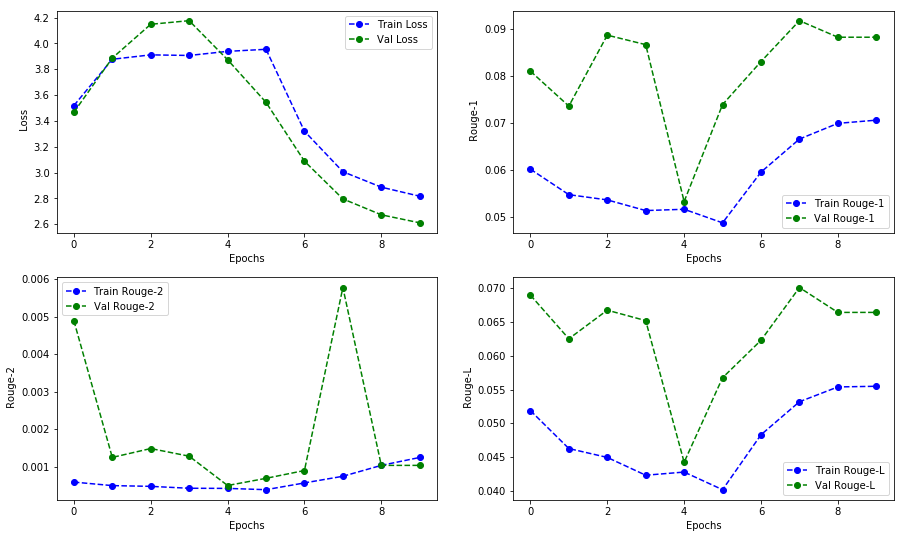

In [0]:
LR = 0.01
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.3
epoch_load = 9

load_checkpoint_history(epoch_load, LR, GRADIENT_CLIPPING, DROPOUT_PROB)

En el segundo caso, se observa:

1. Cierto nivel de Overfitting. Sin embargo, menores valores de función de pérdida que en el caso anterior.
2. Un crecimiento sostenido de la métrica Rouge1 y RougeL, superando el 15%, mejor que en el caso anterior.
3. Un nivel bajo, pero relativamente creciente de la métrica Rouge 2.

Optamos por utilizar esta configuración, que presentó los mejores niveles de Rouge1 y RougeL al final de las 10 épocas de entrenamiento y validación, de entre todas las tuplas.


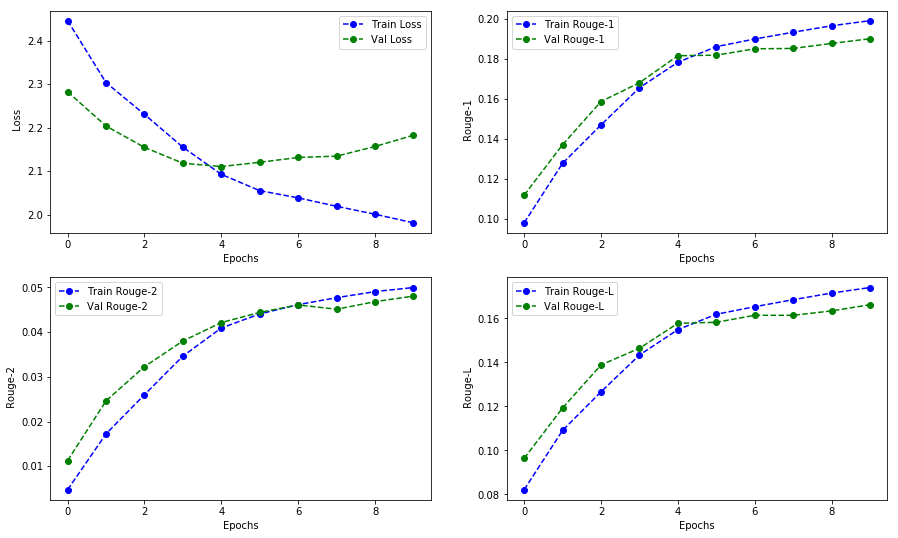

In [0]:
LR = 0.001
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.3
epoch_load = 9

load_checkpoint_history(epoch_load, LR, GRADIENT_CLIPPING, DROPOUT_PROB)

El resto de los exeperimentos dió resutlados como los que se presentan a continuación: 

1. Comportamiento plano de la función de pérdida.
2. Valores bajos para las métricas Rourge, en comparación a las obtenidas anteriormente.


Por lo tanto, se descartan.

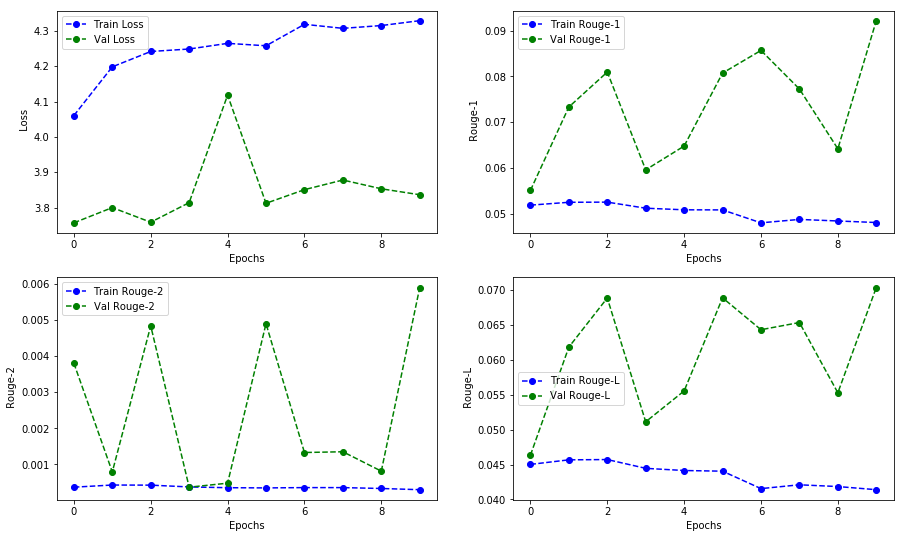

In [0]:
LR = 0.01
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.5
epoch_load = 9

load_checkpoint_history(epoch_load, LR, GRADIENT_CLIPPING, DROPOUT_PROB)

## 2.11 Entrenamiento:  Continuación de Entrenamiento con elección de hiperparámetros.

Como se mencionó, se continuó trabajando con los parámetros encontrados en la búsqueda anterio, en el segundo ejemplo. Un learning rate de 0.001, una probabilidad de dropout de 0.3 .

Se entrenó hasta un total de 40 épocas, lo cual tomó aproximadamente unas 10 horas.

In [0]:
LR = 0.001
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.3
HIDDEN_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DECAY_PATIENCE = 2
LR_DECAY = 0.5

checkpoint_dir = path+"/checkpoints_LR_0.001_GC_{}_DP_{}".format(GRADIENT_CLIPPING, DROPOUT_PROB)
epoch_load = 17
path_final_model = checkpoint_dir+'/p_chechpoint_epch_{}.pkl'
#os.mkdir(checkpoint_dir)



epoch_init = 18
epoch_end = 50


criterion = nn.CrossEntropyLoss()
tsm = TextSummarizerModule(
  embedding=EMBEDDING,
  src_vocab_size=len(train_dataset.src_token2id),
  dst_vocab_size=len(train_dataset.dst_token2id),
  start_idx=train_dataset.src_token2id[train_dataset.START_TOKEN],
  embeddings_size=EMBEDDING.embedding_dim,
  hidden_size=HIDDEN_SIZE,
  dropout_prob=DROPOUT_PROB,
  device = DEVICE)

tsm.to(DEVICE)
optimizer = torch.optim.Adam(tsm.parameters(), lr=LR)

trainer = Trainer(tsm, optimizer, criterion, DEVICE, GRADIENT_CLIPPING, DECAY_PATIENCE, LR_DECAY)

trainer.load_model(path_final_model.format(epoch_load))


In [0]:
trainer.train_model(train_dataset, train_dataloader, dev_dataset, dev_dataloader, epoch_init, epoch_end, path_final_model, path_final_model)

Memoria 0: 1079728640
Memoria 20: 653535744
Memoria 40: 636689920
Memoria 60: 639084544
Memoria 80: 646717440
Memoria 100: 642509824
Memoria 120: 665574400
Memoria 140: 692877312
Memoria 160: 646722560
Memoria 180: 701712896
Memoria 200: 661396480
Memoria 220: 642544128
Memoria 240: 659318272
Memoria 260: 659298304
Memoria 280: 648886784
Memoria 300: 672794624
Memoria 320: 634258944
Memoria 340: 655939584
Memoria 360: 655923200
Memoria 380: 639100928
Memoria 400: 665618432
Memoria 420: 648802304
Memoria 440: 667963392
Memoria 460: 651140096
Memoria 480: 678181376
Memoria 500: 636670464
Memoria 520: 692852736
Memoria 540: 655957504
Memoria 560: 667994112
Memoria 580: 655932928
Memoria 600: 711730688
Memoria 620: 678173184
Memoria 640: 661401600
Memoria 660: 694950400
Memoria 680: 639110144
Memoria 700: 653511680
Memoria 720: 644621312
Memoria 740: 667993088
Memoria 760: 655945216
Memoria 780: 678179328
Memoria 800: 701671936
Memoria 820: 661690880
Memoria 840: 644622336
Memoria 860: 639

Epoch: 10. Train Rouge: [0.20250799 0.05135933 0.17690673], Val Rouge: [0.19061951 0.04725259 0.16625851]
Epoch: 10. Train Loss: 1.9611200082818918, Val Loss: 2.1992974996566774


Memoria 0: 600508928
Memoria 20: 656001536
Memoria 40: 684802560
Memoria 60: 667981312
Memoria 80: 682411520
Memoria 100: 661398016
Memoria 120: 665577984
Memoria 140: 659303424
Memoria 160: 663504896
Memoria 180: 648820736
Memoria 200: 651128320
Memoria 220: 648812544
Memoria 240: 646760960
Memoria 260: 634265088
Memoria 280: 661438464
Memoria 300: 642509824
Memoria 320: 642512896
Memoria 340: 655943168
Memoria 360: 636696064
Memoria 380: 680291328
Memoria 400: 634275328
Memoria 420: 634744320
Memoria 440: 718527488
Memoria 460: 659293184
Memoria 480: 642508288
Memoria 500: 648809984
Memoria 520: 670391808
Memoria 540: 670372864
Memoria 560: 644601856
Memoria 580: 651252224
Memoria 600: 672849408
Memoria 620: 668014592
Memoria 640: 639068672
Memoria 660: 663476224
Memoria 680: 659315200
Memoria 700: 668007424
Memoria 720: 663507456
Memoria 740: 701660160
Memoria 760: 704088064
Memoria 780: 642508288
Memoria 800: 663498240
Memoria 820: 676076544
Memoria 840: 646716928
Memoria 860: 6703

Continuación del entrenamiento...

In [0]:
trainer.train_model(train_dataset, train_dataloader, dev_dataset, dev_dataloader, epoch_init, epoch_end, path_final_model, path_final_model)

Memoria 0: 1139629568
Memoria 20: 712549376
Memoria 40: 681269760
Memoria 60: 695748096
Memoria 80: 666831872
Memoria 100: 706219520
Memoria 120: 683706368
Memoria 140: 678976000
Memoria 160: 683725312
Memoria 180: 691548672
Memoria 200: 700520960
Memoria 220: 689437696
Memoria 240: 706232320
Memoria 260: 676885504
Memoria 280: 683791360
Memoria 300: 686077440
Memoria 320: 669257728
Memoria 340: 689453056
Memoria 360: 676896256
Memoria 380: 672667648
Memoria 400: 683706368
Memoria 420: 669229568
Memoria 440: 743994368
Memoria 460: 723000320
Memoria 480: 686083584
Memoria 500: 710444032
Memoria 520: 681284096
Memoria 540: 689458688
Memoria 560: 693655040
Memoria 580: 715015680
Memoria 600: 666844160
Memoria 620: 683707904
Memoria 640: 686077952
Memoria 660: 664417792
Memoria 680: 689457664
Memoria 700: 676900864
Memoria 720: 708341760
Memoria 740: 689456640
Memoria 760: 672673792
Memoria 780: 695762944
Memoria 800: 678992384
Memoria 820: 710424064
Memoria 840: 678965248
Memoria 860: 678

Epoch: 18. Train Rouge: [0.22043139 0.05827418 0.19644546], Val Rouge: [0.19418931 0.04909776 0.17145885]
Epoch: 18. Train Loss: 1.8101508841297667, Val Loss: 2.5144144569124496


Memoria 0: 601142784
Memoria 20: 643150848
Memoria 40: 639744512
Memoria 60: 637320704
Memoria 80: 676771840
Memoria 100: 671026688
Memoria 120: 656546304
Memoria 140: 643199488
Memoria 160: 659977216
Memoria 180: 643148800
Memoria 200: 647348736
Memoria 220: 659926528
Memoria 240: 651767808
Memoria 260: 676711936
Memoria 280: 687869440
Memoria 300: 671005696
Memoria 320: 664112640
Memoria 340: 664141312
Memoria 360: 649482240
Memoria 380: 645316608
Memoria 400: 656552960
Memoria 420: 645308928
Memoria 440: 664144384
Memoria 460: 662027776
Memoria 480: 645244928
Memoria 500: 673438208
Memoria 520: 690253312
Memoria 540: 649493504
Memoria 560: 668592640
Memoria 580: 656604672
Memoria 600: 662075392
Memoria 620: 668609536
Memoria 640: 649448448
Memoria 660: 755256320
Memoria 680: 654139392
Memoria 700: 664154624
Memoria 720: 651760640
Memoria 740: 670995968
Memoria 760: 752889344
Memoria 780: 654245376
Memoria 800: 637324288
Memoria 820: 676701696
Memoria 840: 654202880
Memoria 860: 6473

Epoch: 19. Train Rouge: [0.22224227 0.05923525 0.19847515], Val Rouge: [0.19410678 0.04907091 0.17118867]
Epoch: 19. Train Loss: 1.802959811122117, Val Loss: 2.519609725134713


Memoria 0: 601142784
Memoria 20: 651769856
Memoria 40: 645245952
Memoria 60: 637314560
Memoria 80: 668662272
Memoria 100: 637329920
Memoria 120: 659942912
Memoria 140: 659936256
Memoria 160: 643149312
Memoria 180: 662042112
Memoria 200: 656557568
Memoria 220: 647343104
Memoria 240: 671017472
Memoria 260: 678814720
Memoria 280: 683154944
Memoria 300: 647343616
Memoria 320: 666210816
Memoria 340: 668611584
Memoria 360: 671006720
Memoria 380: 662053888
Memoria 400: 683036160
Memoria 420: 647334912
Memoria 440: 637319680
Memoria 460: 659935232
Memoria 480: 668589568
Memoria 500: 666245120
Memoria 520: 664154624
Memoria 540: 699893760
Memoria 560: 662039040
Memoria 580: 719157760
Memoria 600: 651758592
Memoria 620: 680915456
Memoria 640: 666260992
Memoria 660: 645274112
Memoria 680: 664121344
Memoria 700: 656576512
Memoria 720: 662053888
Memoria 740: 699908096
Memoria 760: 676724224
Memoria 780: 643169280
Memoria 800: 673414144
Memoria 820: 666216960
Memoria 840: 664118784
Memoria 860: 6976

Epoch: 20. Train Rouge: [0.22434109 0.06017588 0.20088832], Val Rouge: [0.19653248 0.05017814 0.17328649]
Epoch: 20. Train Loss: 1.7800779915404326, Val Loss: 2.5742477968760897


Memoria 0: 601142784
Memoria 20: 662045184
Memoria 40: 693504512
Memoria 60: 678825472
Memoria 80: 649452032
Memoria 100: 647378944
Memoria 120: 634932224
Memoria 140: 643159552
Memoria 160: 643200512
Memoria 180: 680967680
Memoria 200: 637324288
Memoria 220: 645270528
Memoria 240: 643154432
Memoria 260: 637323776
Memoria 280: 647345152
Memoria 300: 685456896
Memoria 320: 637321216
Memoria 340: 659945472
Memoria 360: 643195904
Memoria 380: 649433600
Memoria 400: 649435648
Memoria 420: 719183360
Memoria 440: 664125952
Memoria 460: 664120832
Memoria 480: 649444352
Memoria 500: 651744768
Memoria 520: 643149824
Memoria 540: 656594432
Memoria 560: 668609536
Memoria 580: 659945984
Memoria 600: 671024640
Memoria 620: 673428992
Memoria 640: 651755520
Memoria 660: 645268992
Memoria 680: 671030272
Memoria 700: 649458176
Memoria 720: 673405440
Memoria 740: 664123904
Memoria 760: 695597568
Memoria 780: 649442304
Memoria 800: 678813184
Memoria 820: 634908160
Memoria 840: 662029824
Memoria 860: 6662

Epoch: 21. Train Rouge: [0.2259222  0.06097592 0.20259217], Val Rouge: [0.1948652 0.0497288 0.1721414]
Epoch: 21. Train Loss: 1.7772944293584112, Val Loss: 2.6065158353533064


Memoria 0: 601142784
Memoria 20: 645241856
Memoria 40: 649440768
Memoria 60: 643159040
Memoria 80: 649444864
Memoria 100: 659927040
Memoria 120: 660106752
Memoria 140: 660009472
Memoria 160: 651754496
Memoria 180: 673444864
Memoria 200: 647358464
Memoria 220: 632651264
Memoria 240: 645241856
Memoria 260: 666234880
Memoria 280: 666246144
Memoria 300: 659995136
Memoria 320: 651750912
Memoria 340: 651742208
Memoria 360: 645235712
Memoria 380: 690270208
Memoria 400: 666252288
Memoria 420: 704735232
Memoria 440: 664120320
Memoria 460: 664142848
Memoria 480: 647328256
Memoria 500: 659983360
Memoria 520: 676707328
Memoria 540: 654167552
Memoria 560: 704749056
Memoria 580: 676705280
Memoria 600: 676777984
Memoria 620: 639707648
Memoria 640: 637343744
Memoria 660: 634895872
Memoria 680: 683035136
Memoria 700: 659943424
Memoria 720: 656564224
Memoria 740: 654188544
Memoria 760: 639727616
Memoria 780: 666232320
Memoria 800: 643145216
Memoria 820: 643146752
Memoria 840: 664125952
Memoria 860: 6767

Epoch: 22. Train Rouge: [0.22802668 0.06145827 0.20478615], Val Rouge: [0.19748869 0.04976098 0.1739755 ]
Epoch: 22. Train Loss: 1.7632701988317756, Val Loss: 2.652781900678362


Memoria 0: 601142784
Memoria 20: 649515008
Memoria 40: 714524160
Memoria 60: 651745792
Memoria 80: 724979712
Memoria 100: 647345664
Memoria 120: 654189056
Memoria 140: 654158336
Memoria 160: 643153920
Memoria 180: 647376896
Memoria 200: 666226688
Memoria 220: 632678912
Memoria 240: 647358464
Memoria 260: 690334720
Memoria 280: 647339520
Memoria 300: 651761152
Memoria 320: 651750400
Memoria 340: 664133632
Memoria 360: 671047680
Memoria 380: 693504000
Memoria 400: 673417728
Memoria 420: 649439744
Memoria 440: 639715840
Memoria 460: 649554432
Memoria 480: 639713792
Memoria 500: 639756288
Memoria 520: 647413248
Memoria 540: 656562176
Memoria 560: 697675776
Memoria 580: 676749312
Memoria 600: 676744192
Memoria 620: 639702528
Memoria 640: 676704256
Memoria 660: 662034432
Memoria 680: 649436160
Memoria 700: 639718912
Memoria 720: 673448448
Memoria 740: 647354368
Memoria 760: 645250560
Memoria 780: 659924480
Memoria 800: 662030336
Memoria 820: 656559616
Memoria 840: 673453056
Memoria 860: 6830

Epoch: 23. Train Rouge: [0.22958645 0.06246695 0.20658668], Val Rouge: [0.19828002 0.05121251 0.17538502]
Epoch: 23. Train Loss: 1.7511843540822323, Val Loss: 2.697305482455662


Memoria 0: 601142784
Memoria 20: 683059200
Memoria 40: 678812672
Memoria 60: 639739392
Memoria 80: 668615168
Memoria 100: 724959232
Memoria 120: 651741184
Memoria 140: 645253632
Memoria 160: 643189248
Memoria 180: 647343616
Memoria 200: 651754496
Memoria 220: 654231552
Memoria 240: 643157504
Memoria 260: 683072512
Memoria 280: 651774464
Memoria 300: 666233344
Memoria 320: 643181568
Memoria 340: 639743488
Memoria 360: 666235392
Memoria 380: 695577600
Memoria 400: 668626944
Memoria 420: 743845888
Memoria 440: 659928064
Memoria 460: 666220544
Memoria 480: 649540608
Memoria 500: 651804160
Memoria 520: 673444352
Memoria 540: 704711168
Memoria 560: 659968000
Memoria 580: 714463232
Memoria 600: 659914752
Memoria 620: 659931136
Memoria 640: 643309568
Memoria 660: 645258240
Memoria 680: 651751424
Memoria 700: 651776000
Memoria 720: 656590848
Memoria 740: 637302272
Memoria 760: 639922688
Memoria 780: 649435648
Memoria 800: 647349248
Memoria 820: 647347200
Memoria 840: 656566784
Memoria 860: 6662

Epoch: 24. Train Rouge: [0.23124992 0.06338564 0.20829872], Val Rouge: [0.19780289 0.0502702  0.17544851]
Epoch: 24. Train Loss: 1.737132483754749, Val Loss: 2.7464510679244993


Memoria 0: 601142784
Memoria 20: 643149824
Memoria 40: 634901504
Memoria 60: 647416832
Memoria 80: 639713280
Memoria 100: 645237760
Memoria 120: 649456128
Memoria 140: 685451776
Memoria 160: 668614144
Memoria 180: 643140608
Memoria 200: 687859712
Memoria 220: 668589568
Memoria 240: 645279232
Memoria 260: 654172160
Memoria 280: 664148480
Memoria 300: 645245952
Memoria 320: 654151680
Memoria 340: 649470464
Memoria 360: 651764224
Memoria 380: 693501440
Memoria 400: 683053056
Memoria 420: 676764672
Memoria 440: 647357952
Memoria 460: 687851520
Memoria 480: 651760640
Memoria 500: 647368192
Memoria 520: 702307840
Memoria 540: 662024192
Memoria 560: 668642816
Memoria 580: 637324800
Memoria 600: 683057664
Memoria 620: 647349248
Memoria 640: 662032896
Memoria 660: 714497536
Memoria 680: 741730816
Memoria 700: 666215936
Memoria 720: 695616000
Memoria 740: 649465344
Memoria 760: 702313472
Memoria 780: 645320704
Memoria 800: 645242880
Memoria 820: 659940352
Memoria 840: 750483456
Memoria 860: 6767

Epoch: 25. Train Rouge: [0.23302036 0.06352336 0.21016951], Val Rouge: [0.19698196 0.0507635  0.1744019 ]
Epoch: 25. Train Loss: 1.7195214577369526, Val Loss: 2.7837309088025775


Memoria 0: 601142784
Memoria 20: 668602880
Memoria 40: 654169088
Memoria 60: 651770880
Memoria 80: 643158528
Memoria 100: 678823936
Memoria 120: 690265088
Memoria 140: 678844928
Memoria 160: 659916800
Memoria 180: 637340160
Memoria 200: 643153920
Memoria 220: 664129024
Memoria 240: 645256704
Memoria 260: 748059136
Memoria 280: 714466816
Memoria 300: 649447424
Memoria 320: 647381504
Memoria 340: 654162944
Memoria 360: 676741120
Memoria 380: 671013888
Memoria 400: 666242560
Memoria 420: 647369728
Memoria 440: 659943936
Memoria 460: 668601344
Memoria 480: 678812160
Memoria 500: 659909632
Memoria 520: 676698112
Memoria 540: 647367680
Memoria 560: 649448960
Memoria 580: 651752960
Memoria 600: 656565248
Memoria 620: 651746304
Memoria 640: 662072320
Memoria 660: 659935232
Memoria 680: 671030272
Memoria 700: 671007744
Memoria 720: 668613120
Memoria 740: 645239296
Memoria 760: 680909824
Memoria 780: 664148992
Memoria 800: 651757568
Memoria 820: 647343104
Memoria 840: 643193856
Memoria 860: 6473

Epoch: 26. Train Rouge: [0.23495525 0.06485941 0.21211709], Val Rouge: [0.19652516 0.05047117 0.17332129]
Epoch: 26. Train Loss: 1.710277798557728, Val Loss: 2.8631261205673217


Memoria 0: 601142784
Memoria 20: 659939328
Memoria 40: 676716032
Memoria 60: 632655872
Memoria 80: 762700800
Memoria 100: 719157248
Memoria 120: 643180032
Memoria 140: 668602368
Memoria 160: 671059968
Memoria 180: 654168576
Memoria 200: 651745280
Memoria 220: 651768832
Memoria 240: 707145216
Memoria 260: 664144384
Memoria 280: 687965696
Memoria 300: 643159040
Memoria 320: 649451008
Memoria 340: 760592384
Memoria 360: 702308352
Memoria 380: 634941952
Memoria 400: 647358464
Memoria 420: 659931136
Memoria 440: 645243904
Memoria 460: 683039744
Memoria 480: 656591872
Memoria 500: 664138752
Memoria 520: 659927040
Memoria 540: 668654592
Memoria 560: 666386432
Memoria 580: 651813888
Memoria 600: 710263296
Memoria 620: 634956800
Memoria 640: 666229760
Memoria 660: 738443264
Memoria 680: 659954688
Memoria 700: 683042304
Memoria 720: 651745792
Memoria 740: 639725568
Memoria 760: 656581632
Memoria 780: 666244096
Memoria 800: 639717888
Memoria 820: 637309952
Memoria 840: 685460992
Memoria 860: 6397

Epoch: 27. Train Rouge: [0.2363026  0.06547984 0.21355927], Val Rouge: [0.19898599 0.05167885 0.17638057]
Epoch: 27. Train Loss: 1.701648168691957, Val Loss: 2.867356454985482


Memoria 0: 601142784
Memoria 20: 690254848
Memoria 40: 649433600
Memoria 60: 645243904
Memoria 80: 671006720
Memoria 100: 647355392
Memoria 120: 649487872
Memoria 140: 645320704
Memoria 160: 647338496
Memoria 180: 649453056
Memoria 200: 676785664
Memoria 220: 651752960
Memoria 240: 654193152
Memoria 260: 654157312
Memoria 280: 645258240
Memoria 300: 685472768
Memoria 320: 685476352
Memoria 340: 673428992
Memoria 360: 685449216
Memoria 380: 673411584
Memoria 400: 733612544
Memoria 420: 662014464
Memoria 440: 639740928
Memoria 460: 654162944
Memoria 480: 680925184
Memoria 500: 664121856
Memoria 520: 637317120
Memoria 540: 678841344
Memoria 560: 651739648
Memoria 580: 693478400
Memoria 600: 647377408
Memoria 620: 649453056
Memoria 640: 647381504
Memoria 660: 719146496
Memoria 680: 643174912
Memoria 700: 639724544
Memoria 720: 647361536
Memoria 740: 680963072
Memoria 760: 687848448
Memoria 780: 668592128
Memoria 800: 678808064
Memoria 820: 645233152
Memoria 840: 693619712
Memoria 860: 6397

Epoch: 28. Train Rouge: [0.23832776 0.06620795 0.21569425], Val Rouge: [0.19939467 0.05073903 0.17667022]
Epoch: 28. Train Loss: 1.684298853584979, Val Loss: 2.906601300239563


Memoria 0: 601142784
Memoria 20: 664136192
Memoria 40: 683052032
Memoria 60: 666280448
Memoria 80: 649435136
Memoria 100: 647380992
Memoria 120: 790068224
Memoria 140: 639740416
Memoria 160: 678819840
Memoria 180: 639716352
Memoria 200: 654149632
Memoria 220: 651782656
Memoria 240: 668596736
Memoria 260: 666217984
Memoria 280: 767311872
Memoria 300: 687857664
Memoria 320: 656556032
Memoria 340: 662048768
Memoria 360: 656568832
Memoria 380: 678815232
Memoria 400: 643148288
Memoria 420: 643164672
Memoria 440: 693496832
Memoria 460: 676723712
Memoria 480: 649439232
Memoria 500: 645267968
Memoria 520: 645236736
Memoria 540: 666232320
Memoria 560: 659946496
Memoria 580: 662034432
Memoria 600: 683030528
Memoria 620: 680973312
Memoria 640: 687864832
Memoria 660: 659922944
Memoria 680: 643165184
Memoria 700: 666233344
Memoria 720: 685445120
Memoria 740: 733609984
Memoria 760: 671031296
Memoria 780: 656560640
Memoria 800: 666215936
Memoria 820: 656564224
Memoria 840: 649491456
Memoria 860: 7480

Epoch: 29. Train Rouge: [0.23966453 0.0663329  0.21689311], Val Rouge: [0.200704   0.05051061 0.17715404]
Epoch: 29. Train Loss: 1.6782196747984925, Val Loss: 2.929330541065761


Memoria 0: 601142784
Memoria 20: 683065344
Memoria 40: 668618240
Memoria 60: 659938816
Memoria 80: 656572928
Memoria 100: 664136192
Memoria 120: 634958848
Memoria 140: 683095552
Memoria 160: 651764736
Memoria 180: 678810112
Memoria 200: 643147776
Memoria 220: 704728576
Memoria 240: 637292544
Memoria 260: 654178304
Memoria 280: 654156800
Memoria 300: 673418240
Memoria 320: 645257728
Memoria 340: 647338496
Memoria 360: 654170112
Memoria 380: 647339008
Memoria 400: 639741440
Memoria 420: 668600832
Memoria 440: 649464320
Memoria 460: 654176256
Memoria 480: 643139584
Memoria 500: 637302784
Memoria 520: 676711936
Memoria 540: 685460480
Memoria 560: 676732416
Memoria 580: 645235200
Memoria 600: 643200512
Memoria 620: 651750400
Memoria 640: 656602624
Memoria 660: 683031552
Memoria 680: 656561152
Memoria 700: 634923520
Memoria 720: 639712256
Memoria 740: 637322752
Memoria 760: 637299712
Memoria 780: 659918336
Memoria 800: 668630528
Memoria 820: 651743744
Memoria 840: 676706816
Memoria 860: 6541

Epoch: 30. Train Rouge: [0.24138714 0.06766915 0.21877348], Val Rouge: [0.20103609 0.0505974  0.17797974]
Epoch: 30. Train Loss: 1.668253635464825, Val Loss: 2.9829681164877755


Memoria 0: 601142784
Memoria 20: 664107520
Memoria 40: 670996992
Memoria 60: 654185984
Memoria 80: 637319680
Memoria 100: 695601664
Memoria 120: 673411584
Memoria 140: 687839232
Memoria 160: 649448448
Memoria 180: 662031360
Memoria 200: 724953600
Memoria 220: 676746752
Memoria 240: 690280448
Memoria 260: 643164160
Memoria 280: 666265088
Memoria 300: 654162944
Memoria 320: 643147264
Memoria 340: 649441280
Memoria 360: 639707136
Memoria 380: 637327360
Memoria 400: 659973632
Memoria 420: 704708608
Memoria 440: 673437696
Memoria 460: 645267456
Memoria 480: 647350784
Memoria 500: 714466304
Memoria 520: 680924160
Memoria 540: 649435136
Memoria 560: 678823424
Memoria 580: 662052864
Memoria 600: 659943936
Memoria 620: 664122880
Memoria 640: 748058624
Memoria 660: 673427968
Memoria 680: 654227968
Memoria 700: 670997504
Memoria 720: 643183616
Memoria 740: 690267136
Memoria 760: 673432576
Memoria 780: 666216960
Memoria 800: 654161920
Memoria 820: 673459200
Memoria 840: 673416192
Memoria 860: 6976

Epoch: 31. Train Rouge: [0.24376712 0.068793   0.22086597], Val Rouge: [0.20157996 0.05250977 0.17867219]
Epoch: 31. Train Loss: 1.6552464600895855, Val Loss: 3.004507119996207


Memoria 0: 601142784
Memoria 20: 656580608
Memoria 40: 643206656
Memoria 60: 643129344
Memoria 80: 727063040
Memoria 100: 651747840
Memoria 120: 666210816
Memoria 140: 659956736
Memoria 160: 643156992
Memoria 180: 651771904
Memoria 200: 685471744
Memoria 220: 654158848
Memoria 240: 632656896
Memoria 260: 645278720
Memoria 280: 673407488
Memoria 300: 685471232
Memoria 320: 647348736
Memoria 340: 666254848
Memoria 360: 649455616
Memoria 380: 678802432
Memoria 400: 676723200
Memoria 420: 676719104
Memoria 440: 643141120
Memoria 460: 647384064
Memoria 480: 693495808
Memoria 500: 690302464
Memoria 520: 659922944
Memoria 540: 643152384
Memoria 560: 683115520
Memoria 580: 647408640
Memoria 600: 649473024
Memoria 620: 656587776
Memoria 640: 659957760
Memoria 660: 671007232
Memoria 680: 643156480
Memoria 700: 654163456
Memoria 720: 643154944
Memoria 740: 664154624
Memoria 760: 649444352
Memoria 780: 666276352
Memoria 800: 647369216
Memoria 820: 651759616
Memoria 840: 656616448
Memoria 860: 6642

Epoch: 32. Train Rouge: [0.24492163 0.06863296 0.22202116], Val Rouge: [0.2012703  0.05240775 0.17765166]
Epoch: 32. Train Loss: 1.6407545680866789, Val Loss: 3.080560985292707


Memoria 0: 601142784
Memoria 20: 687856128
Memoria 40: 645258240
Memoria 60: 659934208
Memoria 80: 654181376
Memoria 100: 699892736
Memoria 120: 656572928
Memoria 140: 671042560
Memoria 160: 666219520
Memoria 180: 664142848
Memoria 200: 693497344
Memoria 220: 649434112
Memoria 240: 645245952
Memoria 260: 673437184
Memoria 280: 716762624
Memoria 300: 659917312
Memoria 320: 651761664
Memoria 340: 699877888
Memoria 360: 643133440
Memoria 380: 668602880
Memoria 400: 664122880
Memoria 420: 643190272
Memoria 440: 662017024
Memoria 460: 659916288
Memoria 480: 643200512
Memoria 500: 647337984
Memoria 520: 645255168
Memoria 540: 695599104
Memoria 560: 643151872
Memoria 580: 643146240
Memoria 600: 664105984
Memoria 620: 680973824
Memoria 640: 702325760
Memoria 660: 662030336
Memoria 680: 643177984
Memoria 700: 649457664
Memoria 720: 643147776
Memoria 740: 647344640
Memoria 760: 678892032
Memoria 780: 683073536
Memoria 800: 668610560
Memoria 820: 634894336
Memoria 840: 647348224
Memoria 860: 6431

Epoch: 33. Train Rouge: [0.24666046 0.06978028 0.22380364], Val Rouge: [0.20100404 0.05247836 0.17779019]
Epoch: 33. Train Loss: 1.6382131789697787, Val Loss: 3.0949402066639493


Memoria 0: 601142784
Memoria 20: 647344128
Memoria 40: 666260992
Memoria 60: 659972608
Memoria 80: 673432576
Memoria 100: 637309952
Memoria 120: 664119296
Memoria 140: 649443328
Memoria 160: 710278144
Memoria 180: 673398784
Memoria 200: 666232320
Memoria 220: 649430528
Memoria 240: 662036480
Memoria 260: 671063040
Memoria 280: 699916800
Memoria 300: 647344128
Memoria 320: 666268672
Memoria 340: 680906752
Memoria 360: 645265920
Memoria 380: 683038208
Memoria 400: 643147776
Memoria 420: 671017984
Memoria 440: 637323776
Memoria 460: 643176448
Memoria 480: 651759104
Memoria 500: 651746304
Memoria 520: 704711168
Memoria 540: 671022592
Memoria 560: 645244928
Memoria 580: 704731648
Memoria 600: 637311488
Memoria 620: 643200000
Memoria 640: 668644352
Memoria 660: 643151360
Memoria 680: 662039040
Memoria 700: 643151360
Memoria 720: 676700160
Memoria 740: 649431552
Memoria 760: 649437696
Memoria 780: 656566272
Memoria 800: 659964928
Memoria 820: 719163904
Memoria 840: 666241024
Memoria 860: 6686

Epoch: 34. Train Rouge: [0.24829263 0.07078094 0.22540786], Val Rouge: [0.20101626 0.0513166  0.17835974]
Epoch: 34. Train Loss: 1.6347337372490327, Val Loss: 3.104124950681414


Memoria 0: 601142784
Memoria 20: 673414656
Memoria 40: 660033024
Memoria 60: 639706112
Memoria 80: 664131584
Memoria 100: 647336448
Memoria 120: 680924160
Memoria 140: 639728128
Memoria 160: 647330816
Memoria 180: 664131072
Memoria 200: 683082240
Memoria 220: 664143360
Memoria 240: 647350272
Memoria 260: 651762176
Memoria 280: 643170816
Memoria 300: 643141120
Memoria 320: 651760640
Memoria 340: 643170816
Memoria 360: 673416192
Memoria 380: 649421312
Memoria 400: 676714496
Memoria 420: 678859776
Memoria 440: 664164352
Memoria 460: 690269184
Memoria 480: 659937792
Memoria 500: 656586752
Memoria 520: 654161920
Memoria 540: 656577024
Memoria 560: 637380608
Memoria 580: 656609792
Memoria 600: 664116736
Memoria 620: 676742656
Memoria 640: 683048448
Memoria 660: 680941568
Memoria 680: 662019072
Memoria 700: 676703744
Memoria 720: 645256192
Memoria 740: 664118272
Memoria 760: 639714816
Memoria 780: 637310976
Memoria 800: 712375296
Memoria 820: 676708864
Memoria 840: 656580608
Memoria 860: 6620

Epoch: 35. Train Rouge: [0.24979501 0.0715404  0.22682416], Val Rouge: [0.20233376 0.05128185 0.17851144]
Epoch: 35. Train Loss: 1.6199677158780237, Val Loss: 3.127658418927874


Memoria 0: 601142784
Memoria 20: 637336576
Memoria 40: 645268992
Memoria 60: 699945984
Memoria 80: 656563200
Memoria 100: 695625216
Memoria 120: 654154752
Memoria 140: 671006720
Memoria 160: 647342080
Memoria 180: 647353344
Memoria 200: 712361984
Memoria 220: 659914752
Memoria 240: 639717376
Memoria 260: 651735040
Memoria 280: 643149312
Memoria 300: 671005696
Memoria 320: 664136704
Memoria 340: 630560768
Memoria 360: 651744256
Memoria 380: 659961856
Memoria 400: 676721152
Memoria 420: 643151872
Memoria 440: 659928064
Memoria 460: 693482496
Memoria 480: 639739392
Memoria 500: 676738560
Memoria 520: 639784448
Memoria 540: 729192960
Memoria 560: 683063808
Memoria 580: 651756544
Memoria 600: 714468864
Memoria 620: 643162624
Memoria 640: 639716352
Memoria 660: 637303296
Memoria 680: 651747840
Memoria 700: 647345152
Memoria 720: 634908160
Memoria 740: 656585216
Memoria 760: 639730176
Memoria 780: 647332352
Memoria 800: 654167552
Memoria 820: 639706112
Memoria 840: 647348736
Memoria 860: 6541

Epoch: 36. Train Rouge: [0.25143265 0.07262288 0.22844399], Val Rouge: [0.20233078 0.05212725 0.17913198]
Epoch: 36. Train Loss: 1.6081553049068598, Val Loss: 3.15536046232496


Memoria 0: 601142784
Memoria 20: 673409536
Memoria 40: 651779072
Memoria 60: 673448448
Memoria 80: 748121088
Memoria 100: 668593152
Memoria 120: 643205120
Memoria 140: 645246976
Memoria 160: 666218496
Memoria 180: 643149824
Memoria 200: 643179008
Memoria 220: 662036480
Memoria 240: 699896832
Memoria 260: 654169088
Memoria 280: 673441792
Memoria 300: 662023168
Memoria 320: 637301248
Memoria 340: 699908096
Memoria 360: 719152128
Memoria 380: 664152576
Memoria 400: 668602368
Memoria 420: 647348224
Memoria 440: 647357952
Memoria 460: 662029824
Memoria 480: 659931136
Memoria 500: 685458944
Memoria 520: 664134656
Memoria 540: 649436160
Memoria 560: 645274112
Memoria 580: 678866432
Memoria 600: 664115200
Memoria 620: 727067136
Memoria 640: 651751424
Memoria 660: 656582656
Memoria 680: 637295616
Memoria 700: 651750912
Memoria 720: 690323968
Memoria 740: 662283776
Memoria 760: 673417216
Memoria 780: 656568320
Memoria 800: 702306816
Memoria 820: 659917312
Memoria 840: 697678848
Memoria 860: 6734

Epoch: 37. Train Rouge: [0.25257578 0.07296142 0.22955524], Val Rouge: [0.20435736 0.05372025 0.18061555]
Epoch: 37. Train Loss: 1.6013504495730886, Val Loss: 3.1843353652954103


Memoria 0: 601142784
Memoria 20: 659932672
Memoria 40: 659949568
Memoria 60: 666267136
Memoria 80: 678821376
Memoria 100: 668595712
Memoria 120: 654167552
Memoria 140: 654187008
Memoria 160: 668617728
Memoria 180: 697698816
Memoria 200: 656557568
Memoria 220: 656582144
Memoria 240: 656572928
Memoria 260: 668642304
Memoria 280: 647337472
Memoria 300: 659924992
Memoria 320: 649498624
Memoria 340: 651747840
Memoria 360: 678801408
Memoria 380: 710303232
Memoria 400: 666222592
Memoria 420: 639729152
Memoria 440: 670995968
Memoria 460: 671185408
Memoria 480: 659926528
Memoria 500: 639716352
Memoria 520: 712410624
Memoria 540: 676774400
Memoria 560: 690283520
Memoria 580: 673416192
Memoria 600: 670996480
Memoria 620: 654153216
Memoria 640: 680958976
Memoria 660: 639728128
Memoria 680: 699908096
Memoria 700: 639707648
Memoria 720: 673422336
Memoria 740: 693491712
Memoria 760: 680914432
Memoria 780: 654159872
Memoria 800: 634899456
Memoria 820: 659973120
Memoria 840: 639754752
Memoria 860: 6373

Epoch: 38. Train Rouge: [0.25483007 0.07356328 0.23169087], Val Rouge: [0.20220189 0.05223502 0.17859122]
Epoch: 38. Train Loss: 1.5917693196319889, Val Loss: 3.242737302780151


Memoria 0: 601142784
Memoria 20: 656563200
Memoria 40: 643194880
Memoria 60: 639740416
Memoria 80: 643163136
Memoria 100: 693483008
Memoria 120: 685454336
Memoria 140: 680902144
Memoria 160: 659923456
Memoria 180: 687863296
Memoria 200: 673408000
Memoria 220: 654154752
Memoria 240: 714451968
Memoria 260: 649451008
Memoria 280: 649450496
Memoria 300: 666276352
Memoria 320: 680896512
Memoria 340: 664352256
Memoria 360: 647352320
Memoria 380: 649445376
Memoria 400: 656556544
Memoria 420: 801175040
Memoria 440: 645276672
Memoria 460: 673408000
Memoria 480: 645247488
Memoria 500: 659951104
Memoria 520: 656566272
Memoria 540: 676697600
Memoria 560: 656550400
Memoria 580: 647336448
Memoria 600: 664120320
Memoria 620: 634928640
Memoria 640: 645324800
Memoria 660: 662078976
Memoria 680: 664148480
Memoria 700: 645249536
Memoria 720: 654170624
Memoria 740: 662030336
Memoria 760: 647392256
Memoria 780: 645259264
Memoria 800: 654160896
Memoria 820: 651761664
Memoria 840: 647351296
Memoria 860: 6397

Epoch: 39. Train Rouge: [0.25624212 0.07455172 0.23314122], Val Rouge: [0.2040854  0.05305673 0.18021253]
Epoch: 39. Train Loss: 1.594189732174948, Val Loss: 3.235333230154855


Memoria 0: 601142784
Memoria 20: 656558592
Memoria 40: 643143168
Memoria 60: 649461760
Memoria 80: 729168384
Memoria 100: 690332672
Memoria 120: 645252608
Memoria 140: 670994944
Memoria 160: 678803456
Memoria 180: 637301760
Memoria 200: 673402368
Memoria 220: 664123392
Memoria 240: 659919872
Memoria 260: 666214400
Memoria 280: 673397760
Memoria 300: 649436672
Memoria 320: 649434112
Memoria 340: 656608256
Memoria 360: 649464832
Memoria 380: 693529088
Memoria 400: 654159360
Memoria 420: 645251072
Memoria 440: 666212352
Memoria 460: 673429504
Memoria 480: 647383552
Memoria 500: 647358976
Memoria 520: 643147776
Memoria 540: 678804992
Memoria 560: 639707136
Memoria 580: 678802944
Memoria 600: 707125760
Memoria 620: 645245440
Memoria 640: 656575488
Memoria 660: 643158528
Memoria 680: 673444864
Memoria 700: 662007808
Memoria 720: 656565248
Memoria 740: 637308416
Memoria 760: 643169792
Memoria 780: 649462272
Memoria 800: 659932672
Memoria 820: 645263360
Memoria 840: 664133120
Memoria 860: 6733

Epoch: 40. Train Rouge: [0.2580194  0.07489118 0.23473419], Val Rouge: [0.20398763 0.05314342 0.18049959]
Epoch: 40. Train Loss: 1.5815497664516724, Val Loss: 3.2891219425201417


Memoria 0: 601142784
Memoria 20: 637325824
Memoria 40: 632652288
Memoria 60: 685444608
Memoria 80: 678835200
Memoria 100: 664198144
Memoria 120: 673435648
Memoria 140: 651783680
Memoria 160: 664121856
Memoria 180: 651754496
Memoria 200: 676698624
Memoria 220: 668590592
Memoria 240: 687865344
Memoria 260: 656585728
Memoria 280: 647409664
Memoria 300: 685433344
Memoria 320: 654153216
Memoria 340: 649466880
Memoria 360: 671059968
Memoria 380: 662029824
Memoria 400: 649445376
Memoria 420: 647355904
Memoria 440: 643166208
Memoria 460: 645271040
Memoria 480: 678809088
Memoria 500: 637360128
Memoria 520: 651748352
Memoria 540: 673420800
Memoria 560: 670996480
Memoria 580: 647359488
Memoria 600: 643165696
Memoria 620: 659957248
Memoria 640: 678815232
Memoria 660: 643176448
Memoria 680: 664110080
Memoria 700: 704708096
Memoria 720: 671029760
Memoria 740: 673404928
Memoria 760: 678821376
Memoria 780: 690276864
Memoria 800: 635038720
Memoria 820: 639707136
Memoria 840: 639783936
Memoria 860: 6517

## 2.12 Entrenamiento: Función de Pérdida y Métricas Rouge-1,  Rouge-2 y Rouge-L para modelo final.

Una vez entrenada, se observa los valores obtenidos para las métricas entre las épocas 20 y 40 (los valores entre las épocas 10 a la 20 los sobre escribí por error y no están correctos).

Se observa que:

1. Hay un Gap de Overfitting. Este gap no es del todo critico: La función de pérdida no representa exactamente la tarea buscada. En particular, no penaliza las palabras repetidas, por lo cual no es tan grave que exista cierto gap, en favor de las métricas de desempeño.

2. Si bien las métricas rouge poseen un valor relativamente alto (rouge1 y rouge2) en comparación a los otros casos mostrados, se ve que estan estancadas, creciendo debilemente a lo largo de las épocas. Esto nuevamente se podría explicar, entre otras cosas, por la función de pérdida.

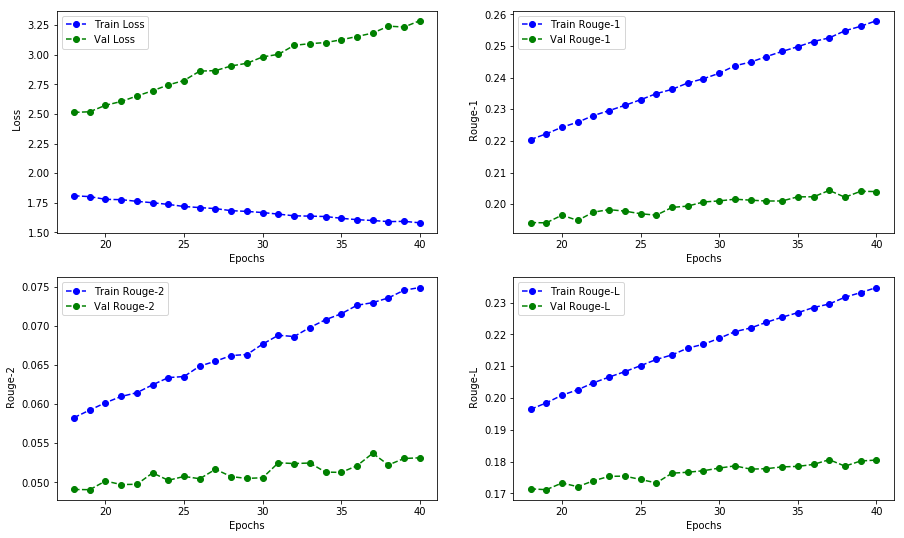

In [25]:
LR = 0.001
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.3
epoch_load = 40

load_checkpoint_history(epoch_load, LR, GRADIENT_CLIPPING, DROPOUT_PROB)

# 3. Actividad 3

## 3.1 Evaluación: Función de evaluación ad-hoc

Finalmente se evalúa el modelo entrenado. Para ello se construye una función que además de calcular las métricas sobre los batch de testeo, devuelve algunas sentencias para ser observadas.

In [0]:
LR = 0.001
GRADIENT_CLIPPING = 5
DROPOUT_PROB = 0.3
HIDDEN_SIZE = 256
DECAY_PATIENCE = 2
LR_DECAY = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



checkpoint_dir = path+"/checkpoints_LR_{}_GC_{}_DP_{}".format(LR, GRADIENT_CLIPPING, DROPOUT_PROB)
epoch_load = 40
path_final_model = checkpoint_dir+'/p_chechpoint_epch_{}.pkl'.format(epoch_load)



In [0]:
def evaluation(path_load_model, test_dataset, testdataloader): 
  criterion = nn.CrossEntropyLoss()
  tsm = TextSummarizerModule(
    embedding=EMBEDDING,
    src_vocab_size=len(train_dataset.src_token2id),
    dst_vocab_size=len(train_dataset.dst_token2id),
    start_idx=train_dataset.src_token2id[train_dataset.START_TOKEN],
    embeddings_size=EMBEDDING.embedding_dim,
    hidden_size=HIDDEN_SIZE,
    dropout_prob=DROPOUT_PROB,
    device = DEVICE)
  
  tsm.to(DEVICE)
  optimizer = torch.optim.Adam(tsm.parameters(), lr=LR)
  
  trainer = Trainer(tsm, optimizer, criterion, DEVICE, GRADIENT_CLIPPING, DECAY_PATIENCE, LR_DECAY)
  trainer.load_model(path_load_model.format(epoch_load))
  test_loss, test_acc, display_outputs = trainer.test_routine(test_dataset, test_dataloader, 10)
  
  return test_loss, test_acc, display_outputs

Luego, se ejecuta la evaluación cargando el último modelo Entrenado.

In [57]:
test_loss, test_acc, display_outputs = evaluation(path_final_model, test_dataset, test_dataloader)

## 3.2 Evaluación: Resultados

Se obtiene una pérdida de testeo de 3.51, en la misma linea de lo observado en los gráficos.

In [57]:
test_loss

3.517883402279445

Se obtiene valores de Rouge:

1. Rouge 1: 20.1%
2. Rouge 2: 5.5%
3. Rouge L: 18.4%


In [58]:
test_acc

array([0.20797049, 0.0549911 , 0.18367577])

Finalmente, se observan algunas predicciones comparadas con su verdadero valor:



1.   Ls Frase 0, 1, 6 y 7 obtienen predicciones similares pesar de ser frases distintas. Sin embargo, es notable que aparezca la palabra "understand" en la predicción, haciendo el simil con las palabras "be aware" (Frase 0 real) y "familiarize yourself"(Frase 1 real), etc. Si bien es cierto la predicción no es similar, algo de abstracción se observa. Sin embargo, se observa el problema de la repetición de palabras, el cual no es posible abordar con la función de pérdida actual.
2.   Las frases 4 y 5  son notables en su similitud de significado entre la predicción y la real.
3.  Las frases 2 , 3 y 9 no hace mucho sentido, evidentemente el modelo puede predecir cosas que no guarden verdadera relación con el tema de fondo.
4.  La frase 8 pareciera ir en el sentido correcto (algo desordenada, y faltando la palabra "species", la cual solamente tiene la letra s en la predicción). Sin embargo, existen palabras bien elegidas.



In [58]:
for i in range(len(display_outputs)):
  
  print("Frase {}".format(i))
  print("Predicción:")
  print(display_outputs[i][0][0])
  print("Real:")
  print(display_outputs[i][1][0])
  print("------------------------------------------")


Frase 0
Predicción:
understand the the of the the the the , . .
Real:
be aware of the potential in your area for to be present .
------------------------------------------
Frase 1
Predicción:
understand that you of of the of the of . .
Real:
familiarize yourself with the purpose and meaning of common sense .
------------------------------------------
Frase 2
Predicción:
purchase a your of your . .
Real:
familiarize yourself with strapping options .
------------------------------------------
Frase 3
Predicción:
apply the requirements . .
Real:
determine how much you ’ ve worked for your current employer .
------------------------------------------
Frase 4
Predicción:
talk your doctor .
Real:
meet with your medical doctor .
------------------------------------------
Frase 5
Predicción:
start your muscles . . .
Real:
do barbell squats .
------------------------------------------
Frase 6
Predicción:
understand the the of the the the .
Real:
research the types of fantasy hockey .
----------

# Discusión

## 4.1 Sobre los resultados

De los resultados obtenidos en el entrenamiento, se concluye que:



1.   A nivel de búsqueda de hiperparámetros, si bien se puede perfeccionar la metodología utilizando librerías más modernas, en general después de 10 épocas se observa poco avance en el aprendizaje del modelo. Salvo en el caso utilizado, los valores de las métricas rouge son bastante bajos (cercanos a cero) para casi todos. 
2.   A nivel de función de pérdida, se observa que a mayor overfitting, mejores métricas rouge se comienzan a obtener. Esto no es del todo extraño ya que la función de pérdida empleada no es del todo ad-hoc para el problema en cuestión.

3. Se observa bastante repetición en las frases seleccionadas por el modelo. También se observa un estancamiento en su capacidad para obtener mejores resultados. Sin embargo,  si bien se observan algunas predicciones sin sentido alguno, también se observa una que otra frase con resultados notablemente buenos.

5. Se concluye la importancia de una arquitectura ad-hoc para cada tarea específica de NLP. hay evidencia de que una arquitectura diseñada para traducción, no funcionará adecuadamente para sumarización.



## 4.2 Posibles Mejoras


Para poder obtener mejores resultados, en base a lo mencionado anteriormente, se proponen las siguientes mejoras que debido a limitaciones temporales no fue posible implementar sin errores.



1.   Implementar un mecanismo de atención no solamente a nivel de Encoder, sino que a nivel de Decoder. Esto permitira evitar repeticiones en las palabras ya escritas.

2.   Implementar una función de pérdida que incorpore este mecanismo de atención de manera que sea parte del objetivo del optimizador.

3.  Implementar una estrategia de búsqueda de hiperparámetros sistematizada. Actualmente, empresas como Facebook están desarrollando Frameworks como Ax [3] que permiten llevar la experimentación de Deep Learning a nuevos niveles.

4. Opcionalmente, implementar un mecanismo de reinforcement learning que permita entregar como refuerzo a la función de pérdida los valores de la métrica Rouge. Me parece que este es el enfoque se debería seguir si se quiere que el modelo alcance un nivel de abstracción superior.

5. Adicionalmente, procurar utiliar una base de datos con una mayor cantidad de registros para fortalecer el entrenamiento del modelo. Sin embargo, esto influirá en el costo computacional.



# Referencias

[1]  Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. *GloVe: Global Vectors for Word Representation*. Disponible en: https://nlp.stanford.edu/projects/glove/

[2] Radim Rehurek and Petr Sojka. 2010. *Software Framework for Topic Modelling with Large Corpora*. Disponible en: https://radimrehurek.com/gensim/

[3] Facebook. *Adaptive Experimentation Platform*. Disponible en https://ax.dev/.